**Aspect Extraction (Using Common Aspects Generated by LLM)**<br>
**Sentiment Analysis Using Vader**<br>
**ABSA Using RoBERTa**<br>

In [4]:
import json
import pandas as pd
import re
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from wordcloud import WordCloud
from transformers import pipeline

nltk.download('vader_lexicon')
nltk.download('stopwords')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\koole\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\koole\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [5]:
# Load Data
with open("data.json", "r", encoding="utf-8") as f:
    data = json.load(f)

# Flatten JSON Data
flattened_data = []
for channel, playlists in data.items():
    for playlist_id, videos in playlists.items():
        for video_id, video_data in videos.items():
            for comment in video_data.get('comments', []):
                flattened_data.append({
                    "channel": channel,
                    "video_id": video_id,
                    "video_title": video_data.get("video_title", ""),
                    "timestamp": comment["Timestamp"],
                    "comment": comment["Comment"]
                })

df = pd.DataFrame(flattened_data)

# Preprocess Comments
def clean_text(text):
    text = text.lower()
    text = re.sub(r'http\S+', '', text)  # Remove URLs
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove non-alphabetic characters
    text = ' '.join([word for word in text.split() if word not in stopwords.words('english')])
    return text.strip()

df["cleaned_text"] = df["comment"].apply(clean_text)

# Aspect Extraction (Frequency-based Approach)
def extract_aspects(text):
    words = text.split()
    common_aspects = ["battery", "price", "design", "performance", "charging", "software", "quality"]   # As defined by LLM
    aspects = [word for word in words if word in common_aspects]
    return aspects

df["aspects"] = df["cleaned_text"].apply(extract_aspects)

In [ ]:
# # Sentiment Analysis using VADER
# sia = SentimentIntensityAnalyzer()

# def get_sentiment(text):
#     scores = sia.polarity_scores(text)
#     if scores["compound"] > 0.05:
#         return "positive"
#     elif scores["compound"] < -0.05:
#         return "negative"
#     else:
#         return "neutral"

# df["sentiment_vader"] = df["cleaned_text"].apply(get_sentiment)

In [ ]:
# # Aspect-Based Sentiment using BART
# aspect_pipeline = pipeline("text-classification", model="facebook/bart-large-mnli")

# def get_aspect_sentiment(text):
#     if not text:
#         return "neutral"
#     result = aspect_pipeline(text)[0]["label"]
#     return result.lower()

# df["sentiment_bart"] = df["cleaned_text"].apply(get_aspect_sentiment)

In [ ]:
# # Preprocess Comments
# def clean_text(text):
#     text = text.lower()
#     text = re.sub(r'http\S+', '', text)  # Remove URLs
#     text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove non-alphabetic characters
#     text = ' '.join([word for word in text.split() if word not in stopwords.words('english')])
#     return text.strip()

# df["cleaned_text"] = df["comment"].apply(clean_text)

# # Aspect Extraction 
# def extract_aspects(text):
#     words = text.split()
#     common_aspects = ["battery", "price", "design", "performance", "charging", "software", "quality"]   # As defined by LLM
#     aspects = [word for word in words if word in common_aspects]
#     return aspects

# df["aspects"] = df["cleaned_text"].apply(extract_aspects)

In [ ]:
# # Sentiment Analysis using VADER
# sia = SentimentIntensityAnalyzer()

# def get_sentiment(text):
#     scores = sia.polarity_scores(text)
#     if scores["compound"] > 0.05:
#         return "positive"
#     elif scores["compound"] < -0.05:
#         return "negative"
#     else:
#         return "neutral"

# df["sentiment_vader"] = df["cleaned_text"].apply(get_sentiment)

In [ ]:
# def get_aspect_sentiment(text):
#     if not text:
#         return "neutral"
#     result = aspect_pipeline(text)[0]["label"]
#     return result.lower()

# df["sentiment_bart"] = df["cleaned_text"].apply(get_aspect_sentiment)

In [6]:
import torch
from torch import nn
from transformers import AutoModelForSequenceClassification, AutoTokenizer

# Load the fine-tuned model and tokenizer
model = AutoModelForSequenceClassification.from_pretrained("fine-tuned-roberta-triplet-classification").to("cuda" if torch.cuda.is_available() else "cpu")
tokenizer = AutoTokenizer.from_pretrained("fine-tuned-roberta-triplet-classification")

In [7]:
def predict_sentiment(text):
    # Tokenize the text and prepare inputs
    inputs = tokenizer(text, return_tensors="pt", padding="max_length", truncation=True, max_length=128).to(model.device)

    # Get the model's prediction (logits)
    with torch.no_grad():
        logits = model(**inputs).logits

    # Get the predicted class index (use argmax directly on logits)
    sentiment_class = torch.argmax(logits, dim=1).item()

    # Map the class index to sentiment label
    sentiment_labels = ["Negative", "Neutral", "Positive"]
    sentiment = sentiment_labels[sentiment_class]

    return sentiment

# Apply the function to the cleaned text in your DataFramec
df["sentiment_roberta"] = df["cleaned_text"].apply(predict_sentiment)

# Example to see the new DataFrame with the predicted sentiment
print(df[["comment", "sentiment_roberta"]].head())

                                             comment sentiment_roberta
0  hi.  so you Guy proud of it please prove by buy 1          Positive
1  Tesla still the electric car to beat especiall...          Negative
2                            This didn’t age well……😂          Negative
3                  Good luck VIETNAMESE Electric Car          Positive
4  Why can't Mexico or any Latin American country...          Negative


In [33]:
df.to_csv("comment_sentiment_roberta_PLP2.csv", index=False)

In [34]:
# Data Checking
print(df.head())  # Display the first few rows to confirm the 'aspects' column
print(df.columns)  # Print column names to ensure 'aspects' exists


              channel     video_id  video_title             timestamp  \
0  Fully Charged Show  ZLKh8w3SGr0          NaN  2024-07-22T20:50:29Z   
1  Fully Charged Show  ZLKh8w3SGr0          NaN  2023-08-31T23:33:42Z   
2  Fully Charged Show  ZLKh8w3SGr0          NaN  2023-08-31T14:54:58Z   
3  Fully Charged Show  ZLKh8w3SGr0          NaN  2023-06-09T23:35:28Z   
4  Fully Charged Show  ZLKh8w3SGr0          NaN  2023-06-01T18:02:16Z   

                                             comment  \
0  hi.  so you Guy proud of it please prove by buy 1   
1  Tesla still the electric car to beat especiall...   
2                            This didn’t age well……😂   
3                  Good luck VIETNAMESE Electric Car   
4  Why can't Mexico or any Latin American country...   

                                        cleaned_text aspects sentiment_roberta  
0                      hi guy proud please prove buy      []          Positive  
1  tesla still electric car beat especially drop ...      []  

In [10]:
# # Aggregate sentiment counts per date and channel
# sentiment_counts = df.groupby(["date", "channel"])["sentiment_vader"].value_counts().unstack(fill_value=0).reset_index()

# print(sentiment_counts.head())
# print(sentiment_counts.columns)

In [37]:
# Visualization: Sentiment Trends Over Time
df["timestamp"] = pd.to_datetime(df["timestamp"])
df["date"] = pd.to_datetime(df["timestamp"]).dt.date  # Ensure it's a proper date

# Aggregate sentiment counts per date and channel
sentiment_counts = df.groupby(["date", "channel"])["sentiment_roberta"].value_counts().unstack(fill_value=0).reset_index()

print(sentiment_counts.head())
print(sentiment_counts.columns)


sentiment_roberta        date       channel  Negative  Neutral  Positive
0                  2017-07-26  Now You Know         2        5         6
1                  2017-07-27  Now You Know         3        2        17
2                  2017-07-28  Now You Know         1        1         3
3                  2017-07-29  Now You Know         0        0         1
4                  2017-08-03  Now You Know         0        0         1
Index(['date', 'channel', 'Negative', 'Neutral', 'Positive'], dtype='object', name='sentiment_roberta')


**Extracted List of Unique Aspects**

In [36]:
# Extracted List of Unique Aspects
aspects_list = df.explode("aspects")["aspects"].unique()
print("Unique Aspects:", aspects_list)

Unique Aspects: ['[]' "['design', 'price']" "['quality']"
 "['battery', 'software', 'battery']" "['charging']"
 "['charging', 'price']" "['battery', 'price']" "['price']" "['battery']"
 "['design', 'design']" "['design']" "['quality', 'quality']"
 "['charging', 'charging']" "['price', 'battery']"
 "['battery', 'design', 'design']" "['performance']"
 "['battery', 'battery', 'battery']" "['battery', 'battery']"
 "['design', 'design', 'design', 'design', 'design']"
 "['battery', 'battery', 'battery', 'battery', 'price', 'battery', 'price', 'battery']"
 "['battery', 'charging', 'charging']" "['design', 'software']"
 "['performance', 'battery']" "['design', 'battery']"
 "['performance', 'price']" "['battery', 'design']"
 "['charging', 'battery']"
 "['charging', 'battery', 'charging', 'charging']" "['software']"
 "['battery', 'charging']" "['design', 'charging']"
 "['charging', 'battery', 'charging']"
 "['charging', 'battery', 'charging', 'charging', 'battery']"
 "['charging', 'charging', 'c

**VADER: Percentage of Positive Sentiment Per Aspect**

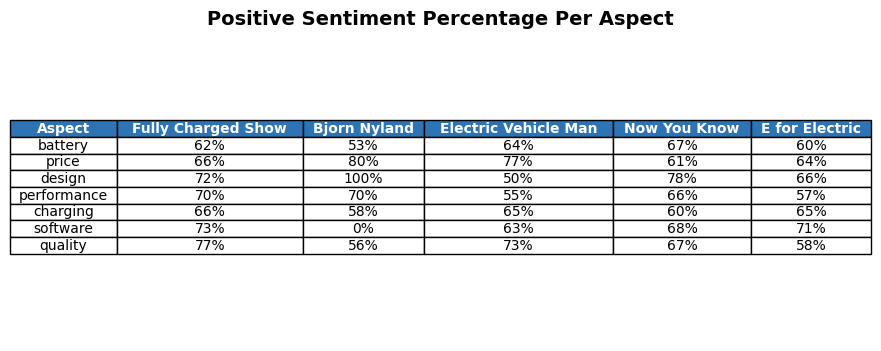

In [ ]:
# # Initialize dictionary to store sentiment counts per creator
# sentiment_counts = {aspect: {} for aspect in common_aspects}

# # Process sentiment data
# for creator in df['channel'].unique():
#     creator_df = df[df['channel'] == creator]
    
#     for aspect in common_aspects:
#         total_mentions = 0
#         positive_mentions = 0
        
#         for aspects, sentiment in zip(creator_df['aspects'], creator_df['sentiment_vader']):
#             if aspect in aspects:
#                 total_mentions += 1
#                 if sentiment == "positive":
#                     positive_mentions += 1
        
#         # Calculate positive sentiment percentage
#         sentiment_counts[aspect][creator] = f"{(positive_mentions / total_mentions * 100):.0f}%" if total_mentions > 0 else "N/A"

# # Convert sentiment data to DataFrame
# sentiment_df = pd.DataFrame(sentiment_counts).T.reset_index()
# sentiment_df.columns = ["Aspect"] + list(df["channel"].unique())

# # Plot the Table
# fig, ax = plt.subplots(figsize=(10, 4))
# ax.axis("tight")
# ax.axis("off")

# # Create the table
# table = ax.table(cellText=sentiment_df.values, 
#                  colLabels=sentiment_df.columns, 
#                  cellLoc='center', 
#                  loc='center')

# # Style the Table
# table.auto_set_font_size(False)
# table.set_fontsize(10)
# table.auto_set_column_width([i for i in range(len(sentiment_df.columns))])

# # Highlight header row
# for key, cell in table.get_celld().items():
#     if key[0] == 0:  # Header row
#         cell.set_text_props(weight='bold', color='white')
#         cell.set_facecolor("#2E74B5")  # Blue Header

# # Add title to the table
# plt.title("Positive Sentiment Percentage Per Aspect", fontsize=14, weight='bold')

# # Display the table
# plt.show()

**RoBERTA: Percentage of Positive Sentiment Per Aspect**

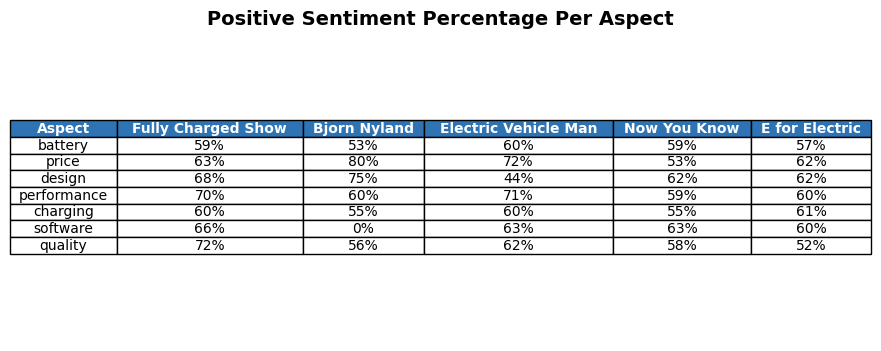

In [39]:
common_aspects = ["battery", "price", "design", "performance", "charging", "software", "quality"] 

# Initialize dictionary to store sentiment counts per creator
sentiment_counts = {aspect: {} for aspect in common_aspects}

# Process sentiment data
for creator in df['channel'].unique():
    creator_df = df[df['channel'] == creator]
    
    for aspect in common_aspects:
        total_mentions = 0
        positive_mentions = 0
        
        for aspects, sentiment in zip(creator_df['aspects'], creator_df['sentiment_roberta']):
            if aspect in aspects:
                total_mentions += 1
                if sentiment == "Positive":
                    positive_mentions += 1
        
        # Calculate positive sentiment percentage
        sentiment_counts[aspect][creator] = f"{(positive_mentions / total_mentions * 100):.0f}%" if total_mentions > 0 else "N/A"

# Convert sentiment data to DataFrame
sentiment_df = pd.DataFrame(sentiment_counts).T.reset_index()
sentiment_df.columns = ["Aspect"] + list(df["channel"].unique())

# Plot the Table
fig, ax = plt.subplots(figsize=(10, 4))
ax.axis("tight")
ax.axis("off")

# Create the table
table = ax.table(cellText=sentiment_df.values, 
                 colLabels=sentiment_df.columns, 
                 cellLoc='center', 
                 loc='center')

# Style the Table
table.auto_set_font_size(False)
table.set_fontsize(10)
table.auto_set_column_width([i for i in range(len(sentiment_df.columns))])

# Highlight header row
for key, cell in table.get_celld().items():
    if key[0] == 0:  # Header row
        cell.set_text_props(weight='bold', color='white')
        cell.set_facecolor("#2E74B5")  # Blue Header

# Add title to the table
plt.title("Positive Sentiment Percentage Per Aspect", fontsize=14, weight='bold')

# Display the table
plt.show()

In [40]:
sentiment_df.to_csv("LLM_sentiment_df_roberta.csv", index=True)

**Overall Sentiment Distribution Per Creator**

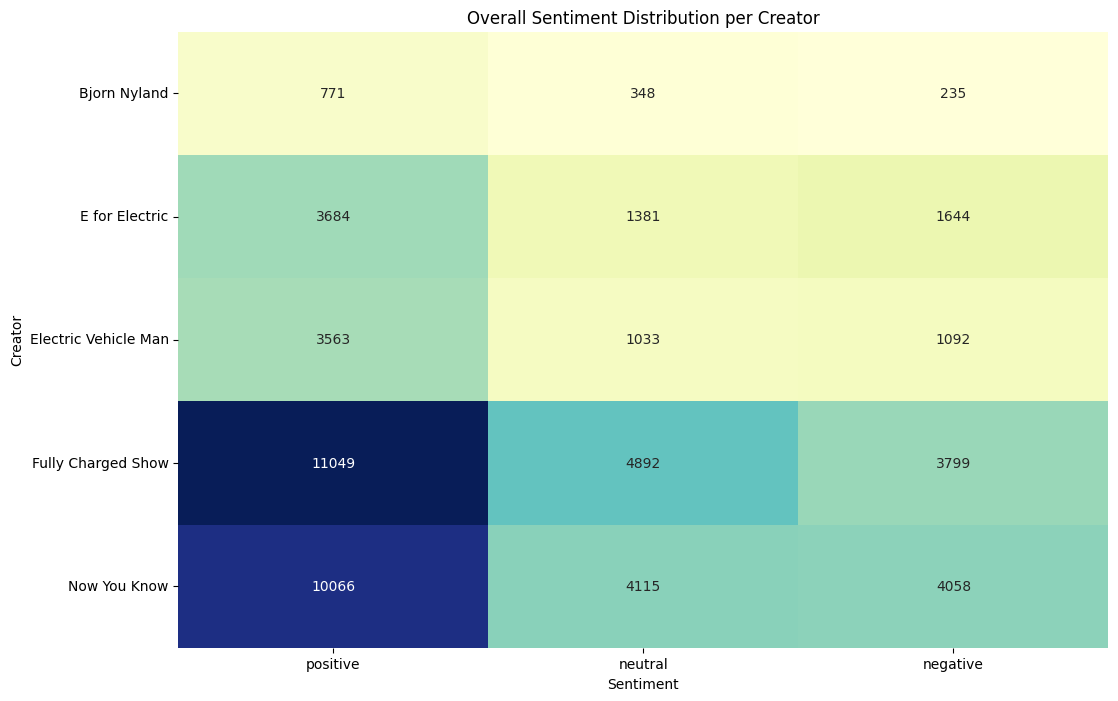

In [ ]:
# # Summarize sentiment distribution per creator
# sentiment_counts = df.groupby(['channel', 'sentiment_vader']).size().unstack(fill_value=0)
# sentiment_counts = sentiment_counts[['positive', 'neutral', 'negative']]  # Ensure the correct order

# # Plot the heatmap for overall sentiment distribution per creator
# plt.figure(figsize=(12, 8))
# sns.heatmap(sentiment_counts, annot=True, cmap="YlGnBu", fmt="d", cbar=False)
# plt.title('Overall Sentiment Distribution per Creator')
# plt.xlabel('Sentiment')
# plt.ylabel('Creator')
# plt.show()

**VADER: Overall Heatmap per Creator: All Aspects Across their Videos**

In [41]:
# for creator in df["channel"].unique():
#     creator_df = df[df["channel"] == creator].explode("aspects")
#     aspect_video_sentiment = creator_df.groupby(["video_id", "aspects", "sentiment_vader"]).size().unstack(fill_value=0)
#     plt.figure(figsize=(15, 8))
#     #sns.heatmap(aspect_video_sentiment, cmap="coolwarm", annot=True, fmt="d")
#     sns.heatmap(aspect_video_sentiment, cmap="coolwarm", annot=False, fmt="d")
#     plt.title(f"Aspect-Based Sentiment for {creator} Across Videos")
#     plt.xlabel("Sentiment")
#     plt.ylabel("Aspect")
#     plt.xticks(rotation=45)
#     plt.show()

**VADER: Aspect-Based Sentiment Comparison per Creator (Each Row is an Aspect, Each Column is a Video)**

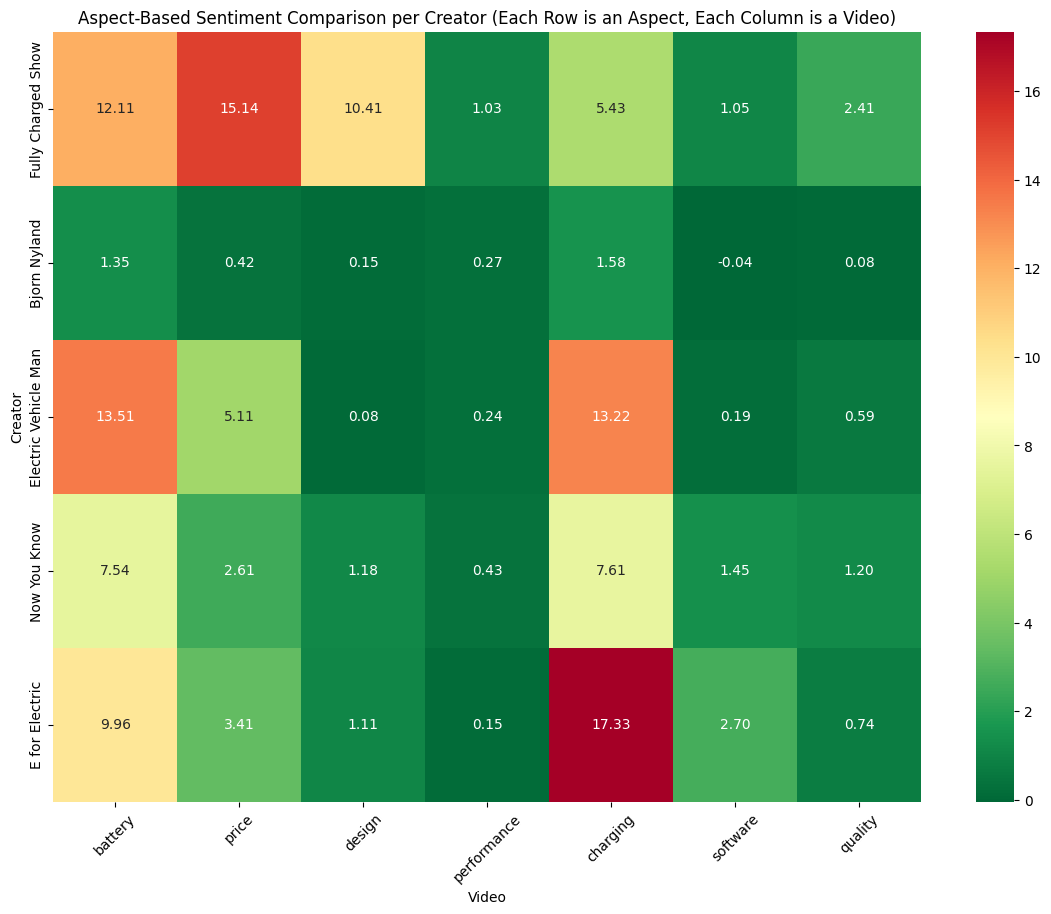

In [ ]:
# import pandas as pd
# import seaborn as sns
# import matplotlib.pyplot as plt

# # Initialize an empty DataFrame to store the results
# aspect_sentiment_matrix = pd.DataFrame()

# # Iterate through each creator and calculate aspect sentiment for each video
# for creator in df['channel'].unique():
#     creator_df = df[df['channel'] == creator]
#     creator_aspect_sentiment = []

#     for video_id in creator_df['video_id'].unique():
#         video_comments = creator_df[creator_df['video_id'] == video_id]
#         aspect_sentiments = {aspect: 0 for aspect in top_aspects}

#         # Update sentiment counts for each aspect in each comment
#         for comment, sentiment in zip(video_comments['aspects'], video_comments['sentiment_vader']):
#             for aspect in comment:
#                 if aspect in aspect_sentiments:
#                     aspect_sentiments[aspect] += 1 if sentiment == "positive" else -1 if sentiment == "negative" else 0

#         creator_aspect_sentiment.append([aspect_sentiments[aspect] for aspect in top_aspects])

#     # Convert the creator_aspect_sentiment list to a DataFrame
#     creator_aspect_sentiment_df = pd.DataFrame(creator_aspect_sentiment, columns=top_aspects)

#     # Add the DataFrame for this creator to the main aspect_sentiment_matrix
#     aspect_sentiment_matrix[creator] = creator_aspect_sentiment_df.mean(axis=0)  # You can use mean or any other aggregation method


# # Plot the heatmap with float formatting
# plt.figure(figsize=(14, 10))
# sns.heatmap(aspect_sentiment_matrix.T, annot=True, cmap="RdYlGn_r", fmt=".2f", cbar=True)
# plt.title("Aspect-Based Sentiment Comparison per Creator (Each Row is an Aspect, Each Column is a Video)")
# plt.xlabel('Video')
# plt.ylabel('Creator')
# plt.xticks(rotation=45)
# plt.show()

**VADER: Heatmap per Creator Per Aspect Per Video (in one Heatmap)** 

Unique Aspects: [nan 'design' 'price' 'quality' 'battery' 'software' 'charging'
 'performance']


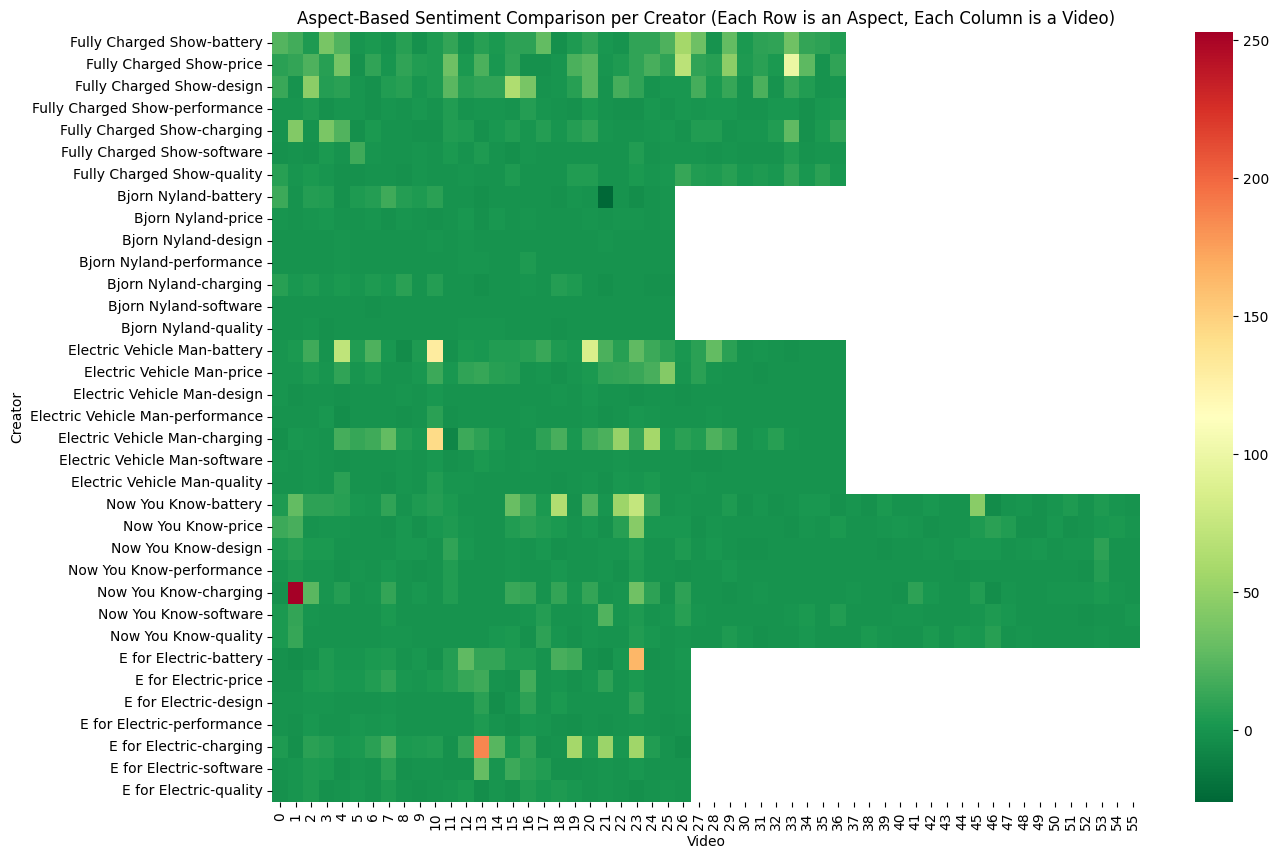

In [ ]:
# import matplotlib.pyplot as plt
# import seaborn as sns
# import pandas as pd

# # Define top aspects (replace or modify these as needed)
# top_aspects = ["battery", "price", "design", "performance", "charging", "software", "quality"]

# # Extracted List of Unique Aspects (You should have this populated already)
# aspects_list = df.explode("aspects")["aspects"].unique()
# print("Unique Aspects:", aspects_list)

# # Initialize a matrix for storing aspect sentiment data for each creator and video
# aspect_sentiment_matrix = []

# # Loop through each creator
# for creator in df['channel'].unique():
#     creator_df = df[df['channel'] == creator]
#     creator_aspect_sentiment = []

#     # Loop through each video
#     for video_id in creator_df['video_id'].unique():
#         video_comments = creator_df[creator_df['video_id'] == video_id]
#         aspect_sentiments = {aspect: 0 for aspect in top_aspects}

#         # Loop through each comment and its sentiment
#         for comment, sentiment in zip(video_comments['aspects'], video_comments['sentiment_vader']):
#             for aspect in comment:
#                 if aspect in aspect_sentiments:
#                     # Increment/decrement based on sentiment
#                     aspect_sentiments[aspect] += 1 if sentiment == "positive" else -1 if sentiment == "negative" else 0

#         # Append the sentiment values for this video
#         creator_aspect_sentiment.append([aspect_sentiments[aspect] for aspect in top_aspects])

#     # Convert the list into a DataFrame for this creator and append it to the matrix
#     creator_df_sentiment = pd.DataFrame(creator_aspect_sentiment, columns=top_aspects)
#     aspect_sentiment_matrix.append(creator_df_sentiment)

# # Concatenate all creator sentiment matrices horizontally (creating columns for each creator)
# aspect_sentiment_matrix = pd.concat(aspect_sentiment_matrix, axis=1, keys=df['channel'].unique())

# # Plot the overall aspect sentiment matrix
# plt.figure(figsize=(14, 10))
# #sns.heatmap(aspect_sentiment_matrix.T, annot=True, cmap="RdYlGn_r", fmt=".2f", cbar=True)  # Use ".2f" for floating point
# sns.heatmap(aspect_sentiment_matrix.T, annot=False, cmap="RdYlGn_r", fmt=".2f", cbar=True)  # Use ".2f" for floating point
# plt.title("Aspect-Based Sentiment Comparison per Creator (Each Row is an Aspect, Each Column is a Video)")
# plt.xlabel('Video')
# plt.ylabel('Creator')
# plt.show()



**VADER: Heatmap per Creator Per Aspect Per Video (One Heatmap Per Creator)** 

Unique Aspects: [nan 'design' 'price' 'quality' 'battery' 'software' 'charging'
 'performance']


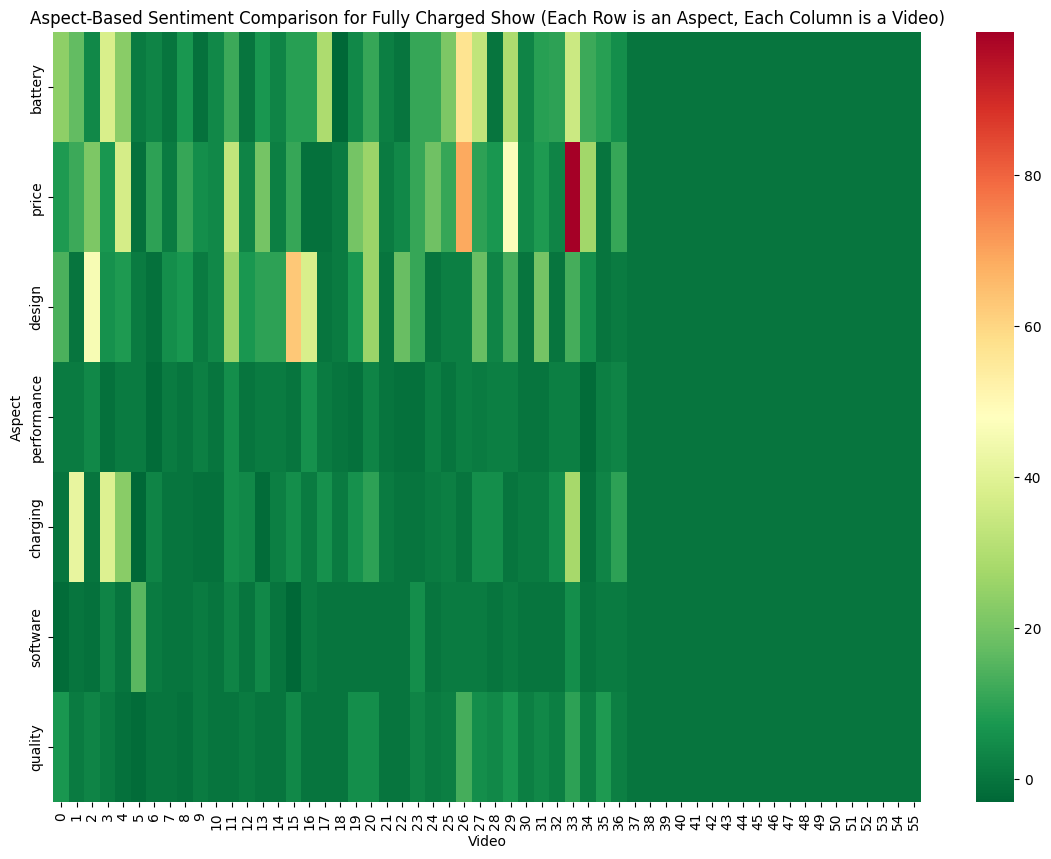

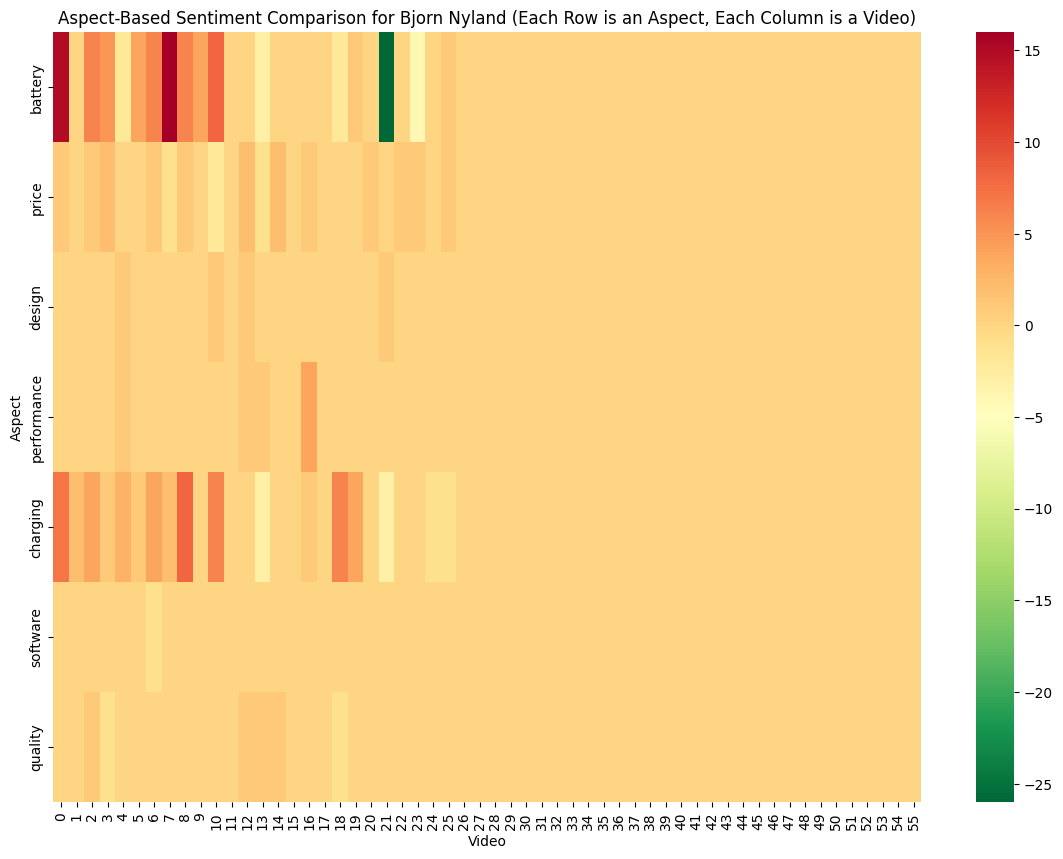

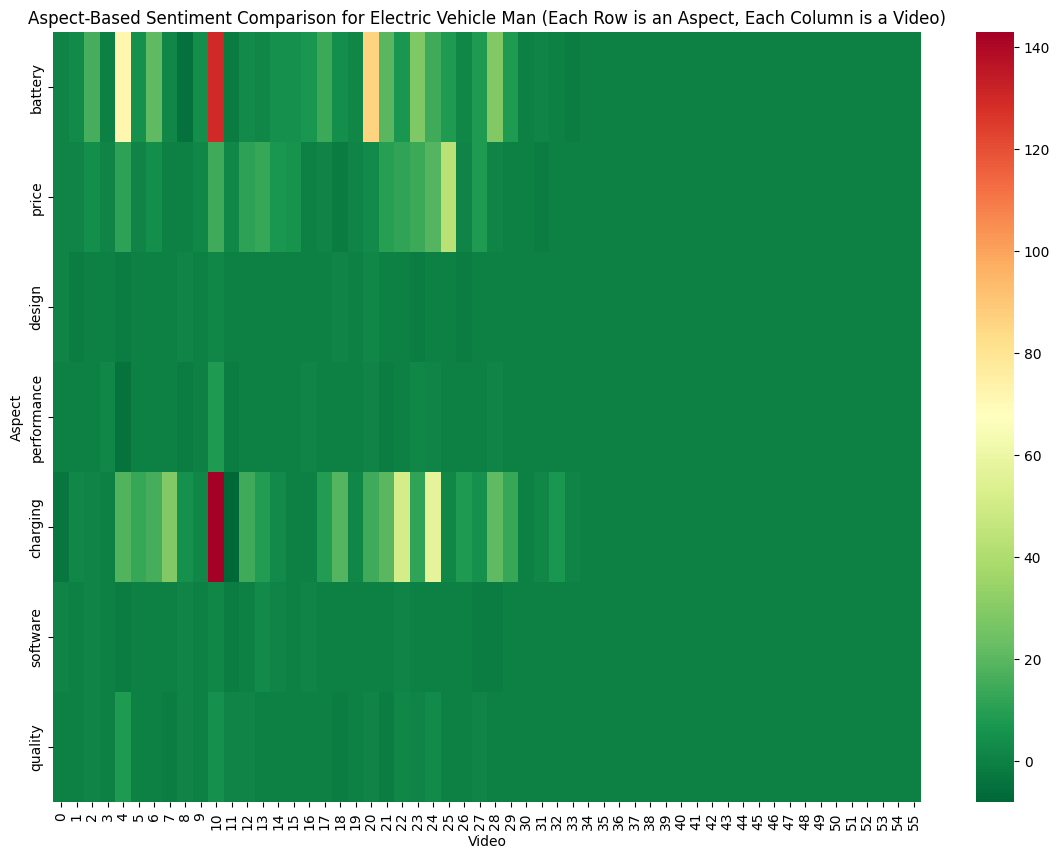

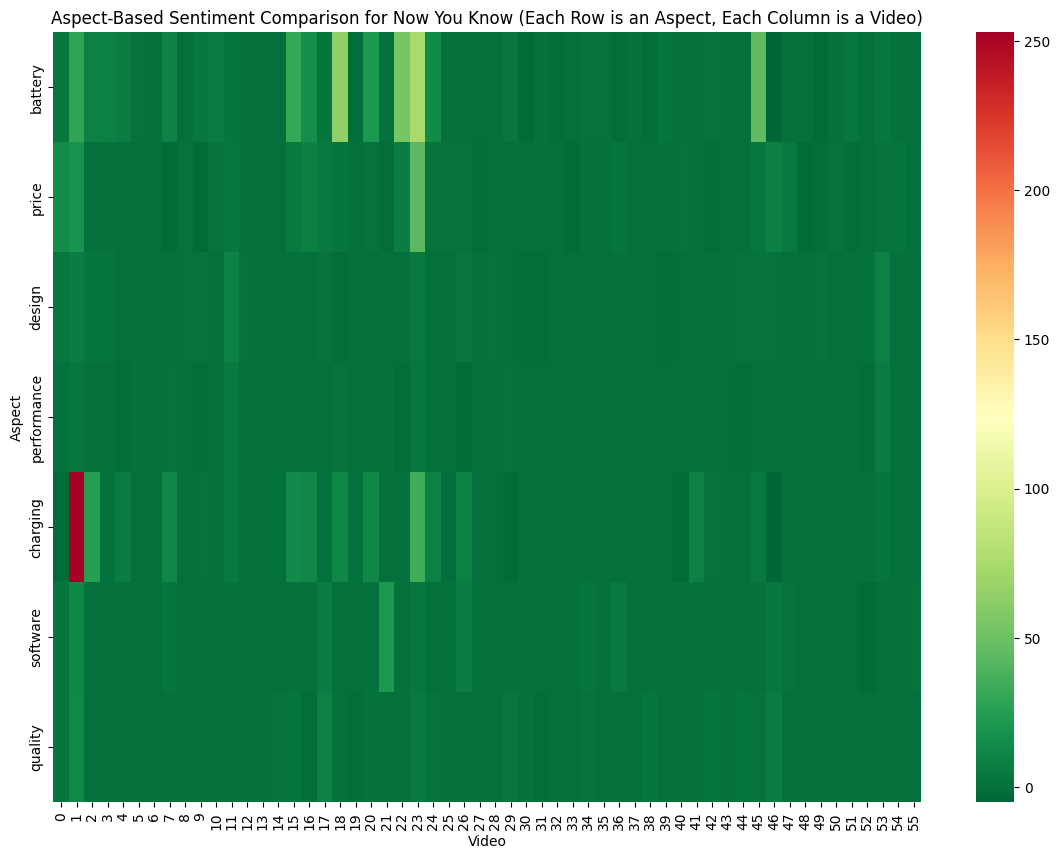

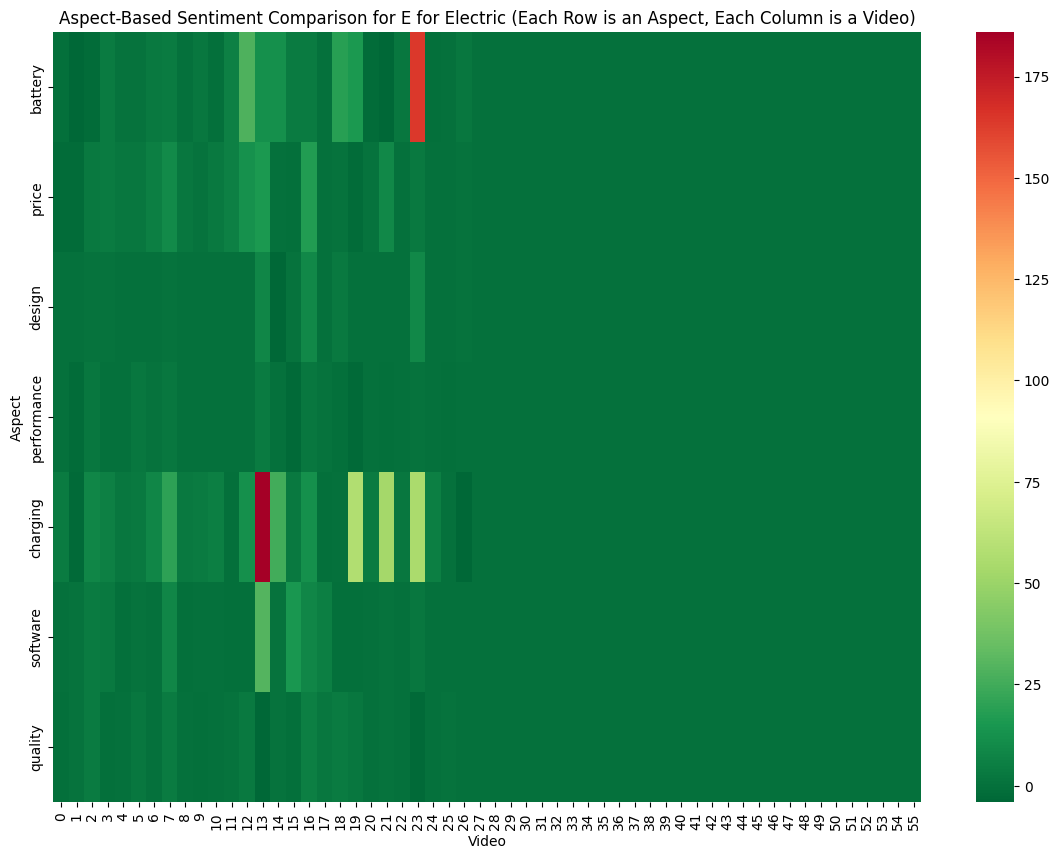

In [ ]:
# import matplotlib.pyplot as plt
# import seaborn as sns
# import pandas as pd

# # Define top aspects (replace or modify these as needed)
# top_aspects = ["battery", "price", "design", "performance", "charging", "software", "quality"]

# # Extracted List of Unique Aspects (You should have this populated already)
# aspects_list = df.explode("aspects")["aspects"].unique()
# print("Unique Aspects:", aspects_list)

# # Initialize a matrix for storing aspect sentiment data for each creator and video
# aspect_sentiment_matrix = []

# # Loop through each creator
# for creator in df['channel'].unique():
#     creator_df = df[df['channel'] == creator]
#     creator_aspect_sentiment = []

#     # Loop through each video
#     for video_id in creator_df['video_id'].unique():
#         video_comments = creator_df[creator_df['video_id'] == video_id]
#         aspect_sentiments = {aspect: 0 for aspect in top_aspects}

#         # Loop through each comment and its sentiment
#         for comment, sentiment in zip(video_comments['aspects'], video_comments['sentiment_vader']):
#             for aspect in comment:
#                 if aspect in aspect_sentiments:
#                     # Increment/decrement based on sentiment
#                     aspect_sentiments[aspect] += 1 if sentiment == "positive" else -1 if sentiment == "negative" else 0

#         # Append the sentiment values for this video
#         creator_aspect_sentiment.append([aspect_sentiments[aspect] for aspect in top_aspects])

#     # Add the creator's aspect sentiment data to the matrix
#     aspect_sentiment_matrix.append(creator_aspect_sentiment)

# # Convert the matrix into a DataFrame, ensuring each video has the same number of columns
# max_videos = max(len(creator_aspect_sentiment) for creator_aspect_sentiment in aspect_sentiment_matrix)

# # Fill with NaNs for creators with fewer videos
# for idx, creator_sentiment in enumerate(aspect_sentiment_matrix):
#     # If there are fewer videos for a creator, pad the list
#     while len(creator_sentiment) < max_videos:
#         creator_sentiment.append([0] * len(top_aspects))

# # Convert into DataFrame, where each row corresponds to an aspect, and each column to a video
# aspect_sentiment_matrix_df = pd.DataFrame(aspect_sentiment_matrix, 
#                                           columns=[f"Video {i+1}" for i in range(max_videos)], 
#                                           index=df['channel'].unique())

# # Now plot for each creator's sentiment data
# for creator, sentiment_data in zip(df['channel'].unique(), aspect_sentiment_matrix):
#     creator_sentiment_df = pd.DataFrame(sentiment_data, columns=top_aspects)
    
#     # Plot the aspect sentiment for this specific creator
#     plt.figure(figsize=(14, 10))
#     #sns.heatmap(creator_sentiment_df.T, annot=True, cmap="RdYlGn_r", fmt=".2f", cbar=True)
#     sns.heatmap(creator_sentiment_df.T, annot=False, cmap="RdYlGn_r", fmt=".2f", cbar=True)
#     plt.title(f"Aspect-Based Sentiment Comparison for {creator} (Each Row is an Aspect, Each Column is a Video)")
#     plt.xlabel('Video')
#     plt.ylabel('Aspect')
#     plt.show()


**Bar Plot: Total Number of Comments per Creator**

C:\Users\koole\AppData\Local\Temp\ipykernel_29484\80756993.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=total_comments.index, y=total_comments.values, palette="viridis")


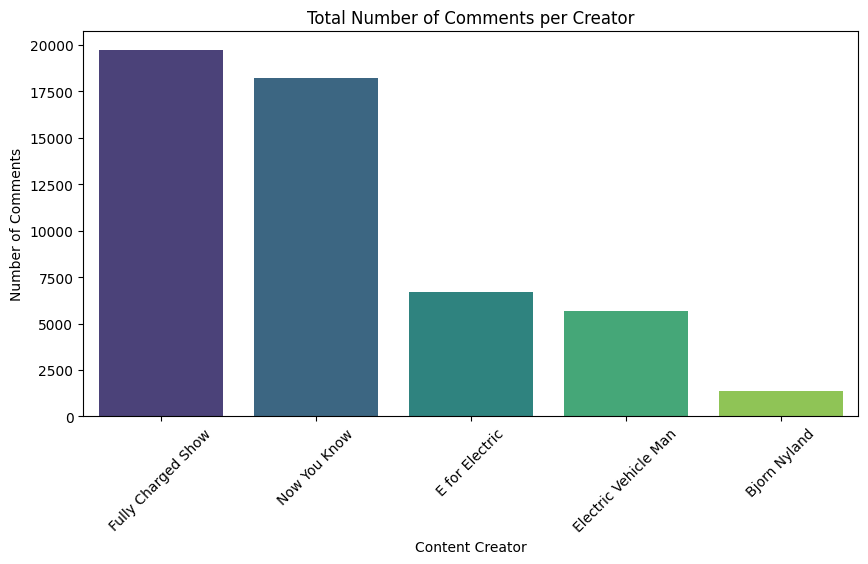

In [ ]:
# total_comments = df["channel"].value_counts()
# plt.figure(figsize=(10, 5))
# sns.barplot(x=total_comments.index, y=total_comments.values, palette="viridis")
# plt.title("Total Number of Comments per Creator")
# plt.xlabel("Content Creator")
# plt.ylabel("Number of Comments")
# plt.xticks(rotation=45)
# plt.show()

**Time Series: Number of Comments Over Time per Creator**

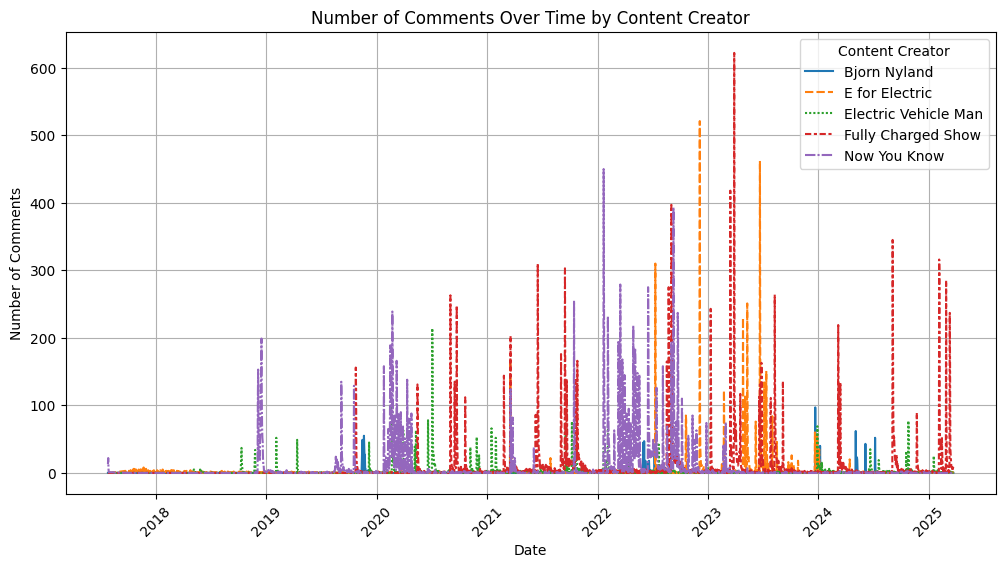

In [ ]:
# comment_time_series = df.groupby(["date", "channel"]).size().unstack(fill_value=0)
# plt.figure(figsize=(12, 6))
# sns.lineplot(data=comment_time_series)
# plt.title("Number of Comments Over Time by Content Creator")
# plt.xlabel("Date")
# plt.ylabel("Number of Comments")
# plt.xticks(rotation=45)
# plt.legend(title="Content Creator")
# plt.grid()
# plt.show()


**VADER: Bar Plot: Total Number of Positive Comments per Creator**

In [ ]:
# print(type(creator_sentiment))  # Verify it's a list
# print(creator_sentiment[:5])    # Print the first 5 elements in the list



<class 'list'>
[[-1, -2, 0, 0, 4, 0, -1], [-4, -2, 0, -2, -3, 1, 1], [-2, 3, 1, 2, 8, 4, 4], [4, 4, 1, 0, 6, 3, -1], [1, 2, 0, 0, 2, -1, 0]]


C:\Users\koole\AppData\Local\Temp\ipykernel_29484\3457485678.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=positive_comments_per_creator.index, y=positive_comments_per_creator.values, palette="viridis")


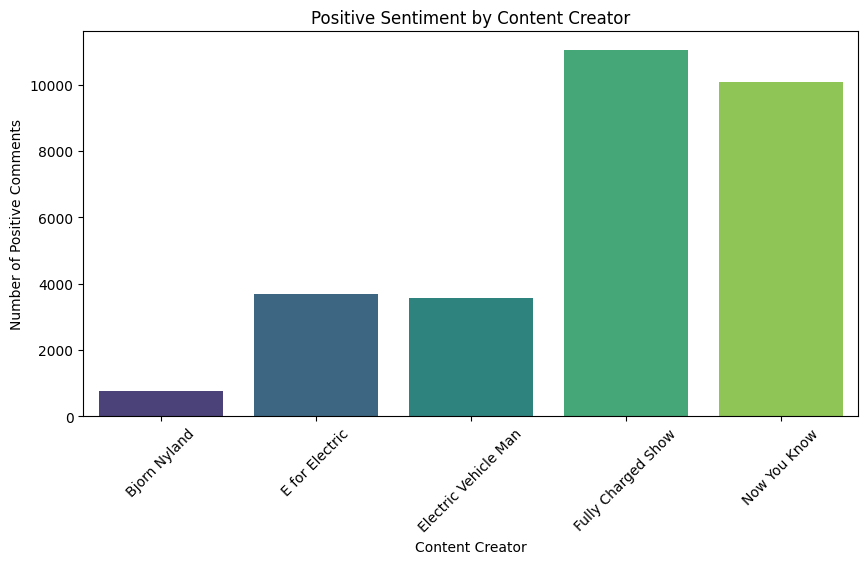

In [ ]:
# # Count the number of positive comments per creator
# positive_comments_per_creator = df[df['sentiment_vader'] == 'positive'].groupby('channel').size()

# # Plotting the number of positive comments per creator
# plt.figure(figsize=(10, 5))
# sns.barplot(x=positive_comments_per_creator.index, y=positive_comments_per_creator.values, palette="viridis")
# plt.title("Positive Sentiment by Content Creator")
# plt.xlabel("Content Creator")
# plt.ylabel("Number of Positive Comments")
# plt.xticks(rotation=45)
# plt.show()


**VADER: Time Series: Number of Positive Comments Over Time per Creator**

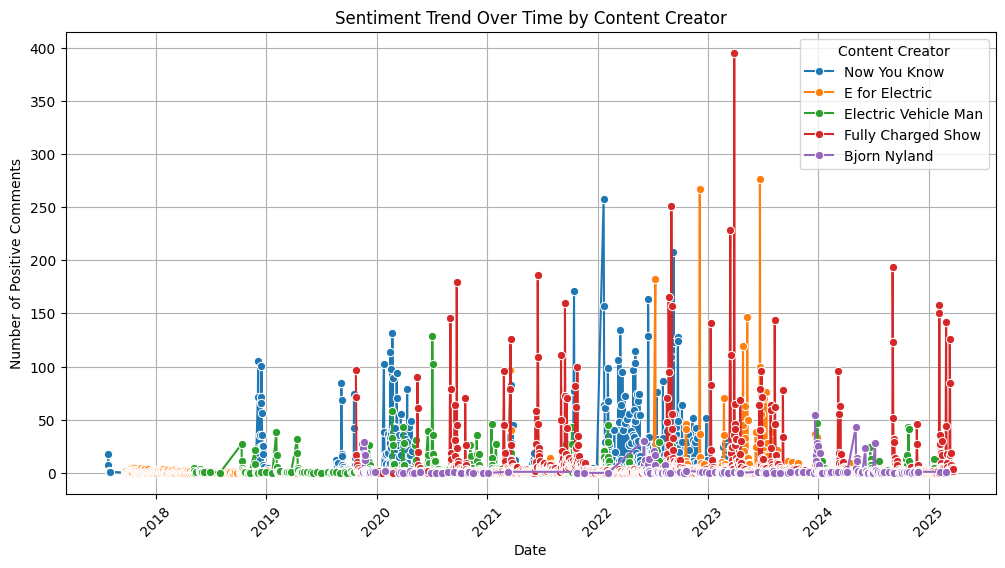

In [ ]:
# # Sentiment Distribution per Aspect
# aspect_sentiment = df.explode("aspects").groupby(["aspects", "sentiment_vader"]).size().unstack(fill_value=0)

# # Compare Content Creators based on Sentiment
# creator_sentiment = df.groupby(["channel", "sentiment_vader"]).size().unstack(fill_value=0)

# # Visualization: Sentiment Trends Over Time
# df["timestamp"] = pd.to_datetime(df["timestamp"])
# df["date"] = pd.to_datetime(df["timestamp"]).dt.date  # Ensure it's a proper date

# # Aggregate sentiment counts per date and channel
# sentiment_counts = df.groupby(["date", "channel"])["sentiment_vader"].value_counts().unstack(fill_value=0).reset_index()

# # Convert "date" back to datetime type
# sentiment_counts["date"] = pd.to_datetime(sentiment_counts["date"])

# # Plot
# plt.figure(figsize=(12, 6))
# sns.lineplot(data=sentiment_counts, x="date", y="positive", hue="channel", marker="o")

# plt.title("Sentiment Trend Over Time by Content Creator")
# plt.xlabel("Date")
# plt.ylabel("Number of Positive Comments")
# plt.xticks(rotation=45)
# plt.legend(title="Content Creator")
# plt.grid()
# plt.show()


**ABSA - RoBERTa**

In [ ]:
# def get_aspect_sentiment_new(text):
#     if not text:
#         return "neutral"
#     result = aspect_pipeline(text)[0]["label"]
    
#     # Map NLI labels to sentiment labels
#     sentiment_map = {
#         "entailment": "positive",
#         "neutral": "neutral",
#         "contradiction": "negative"
#     }
    
#     return sentiment_map.get(result.lower(), "neutral")

# df["sentiment_bart"] = df["cleaned_text"].apply(get_aspect_sentiment_new)

**RoBERTa: Overall Heatmap per Creator: All Aspects Across their Videos**

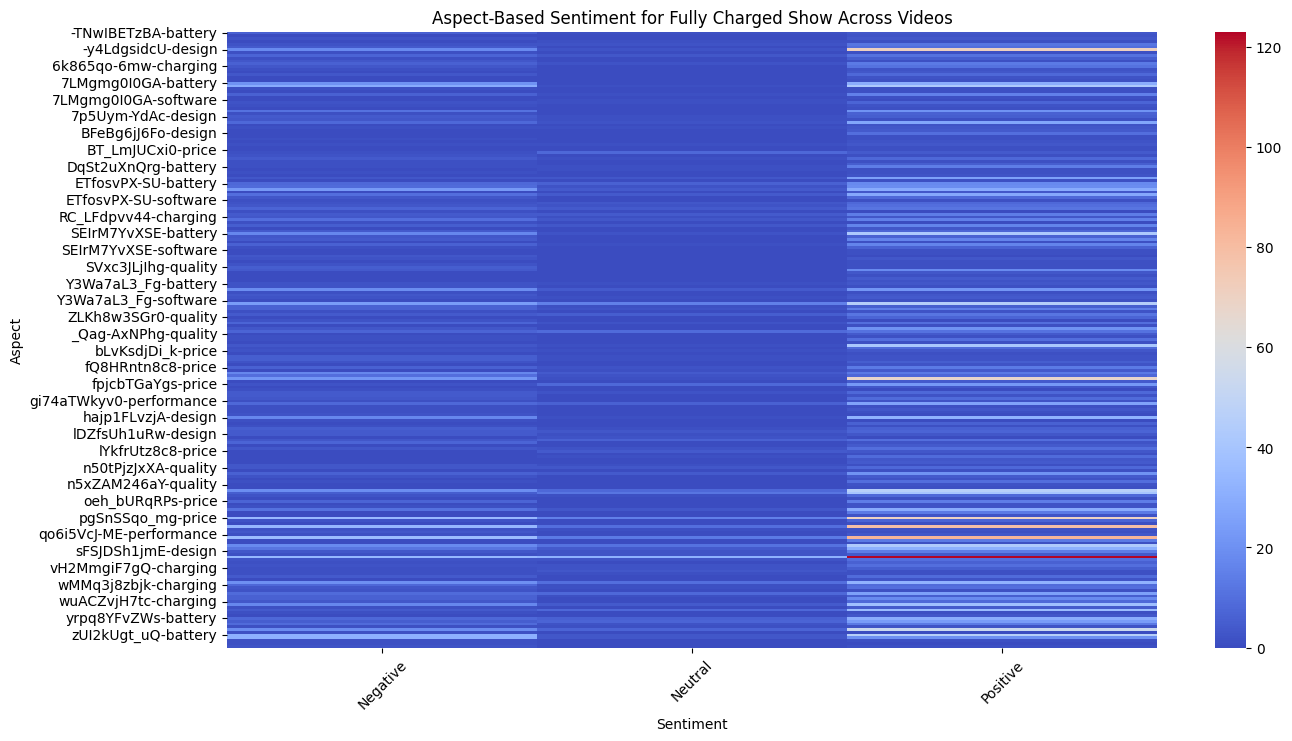

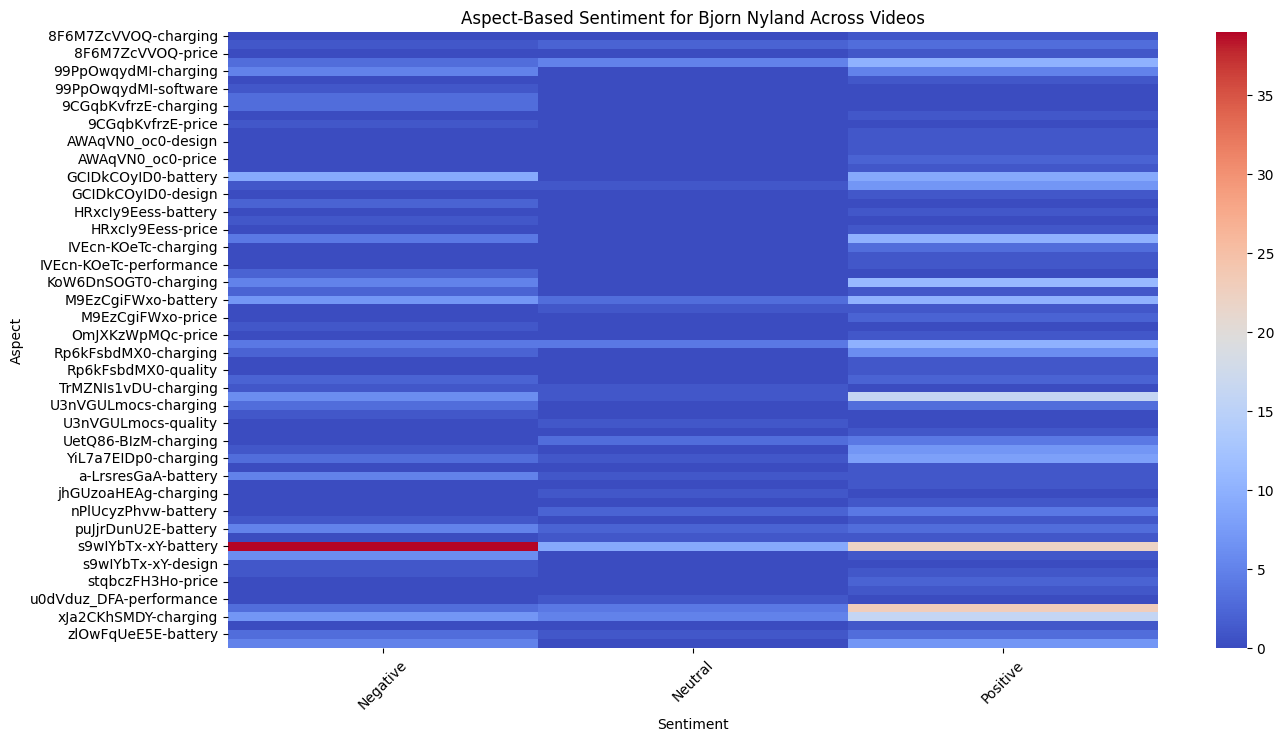

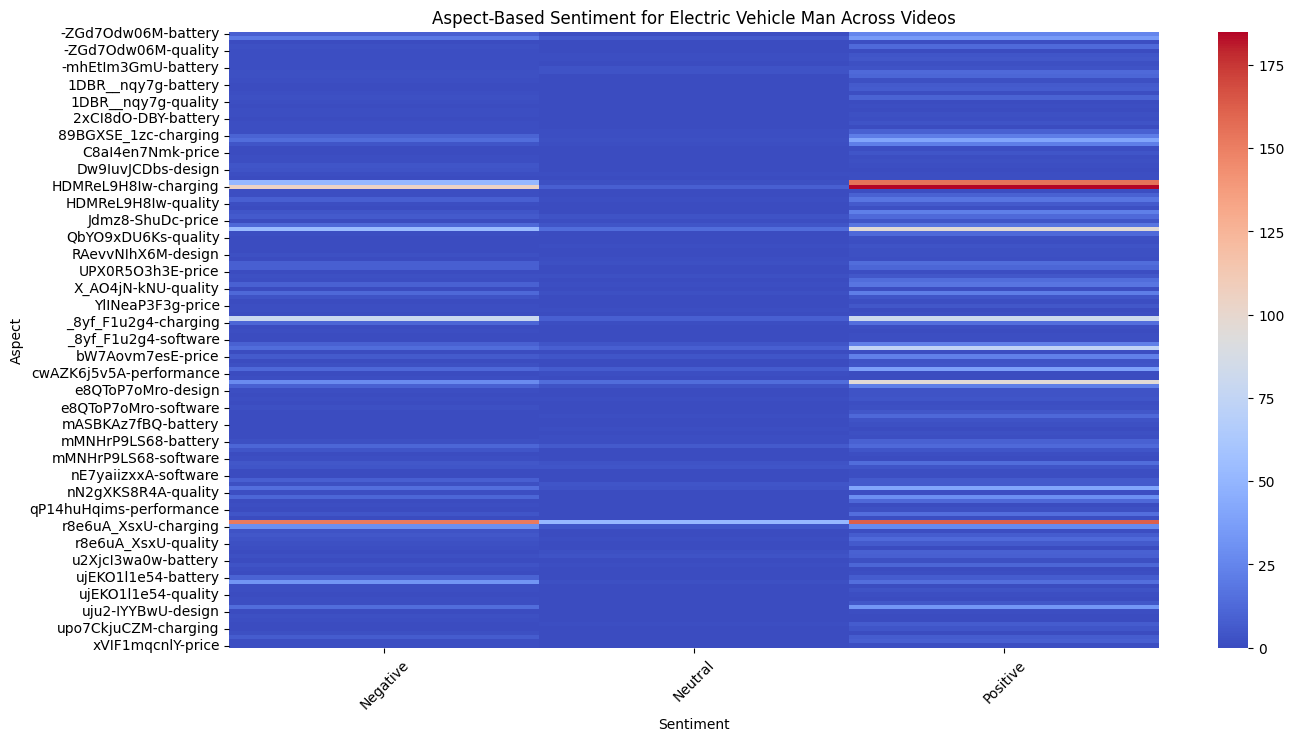

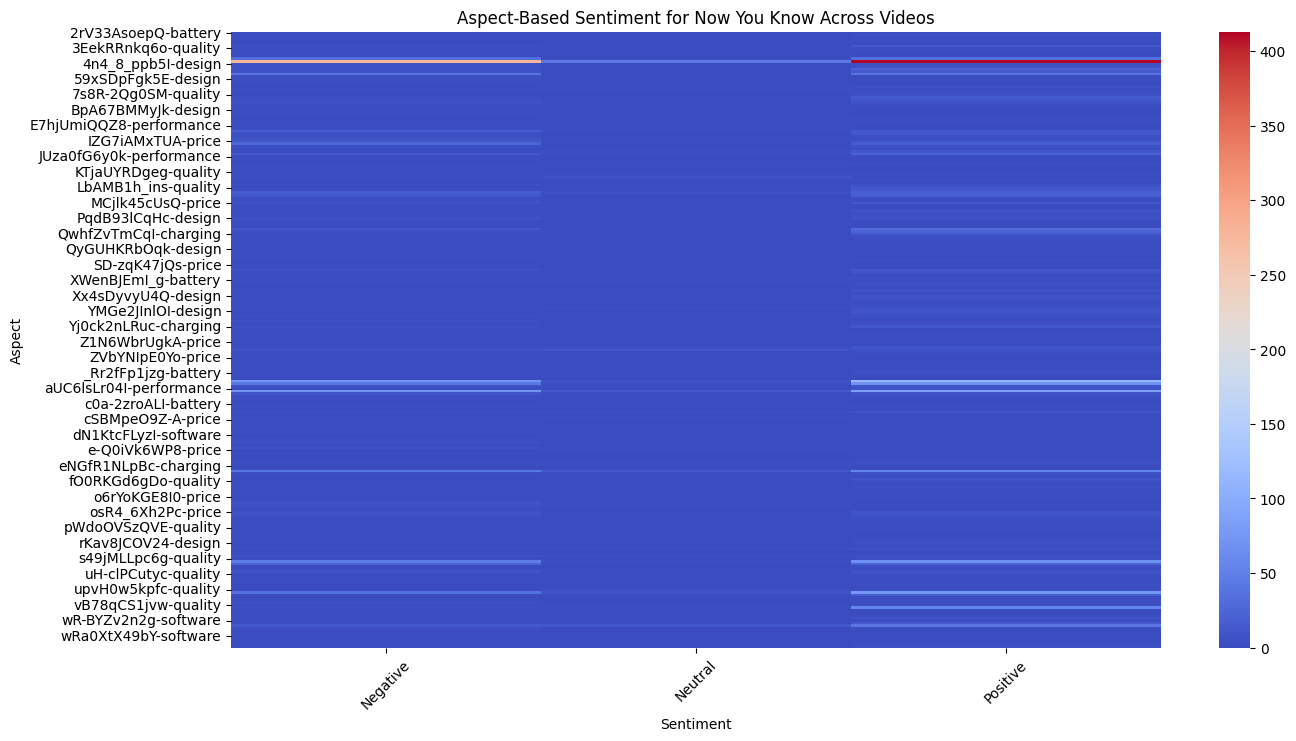

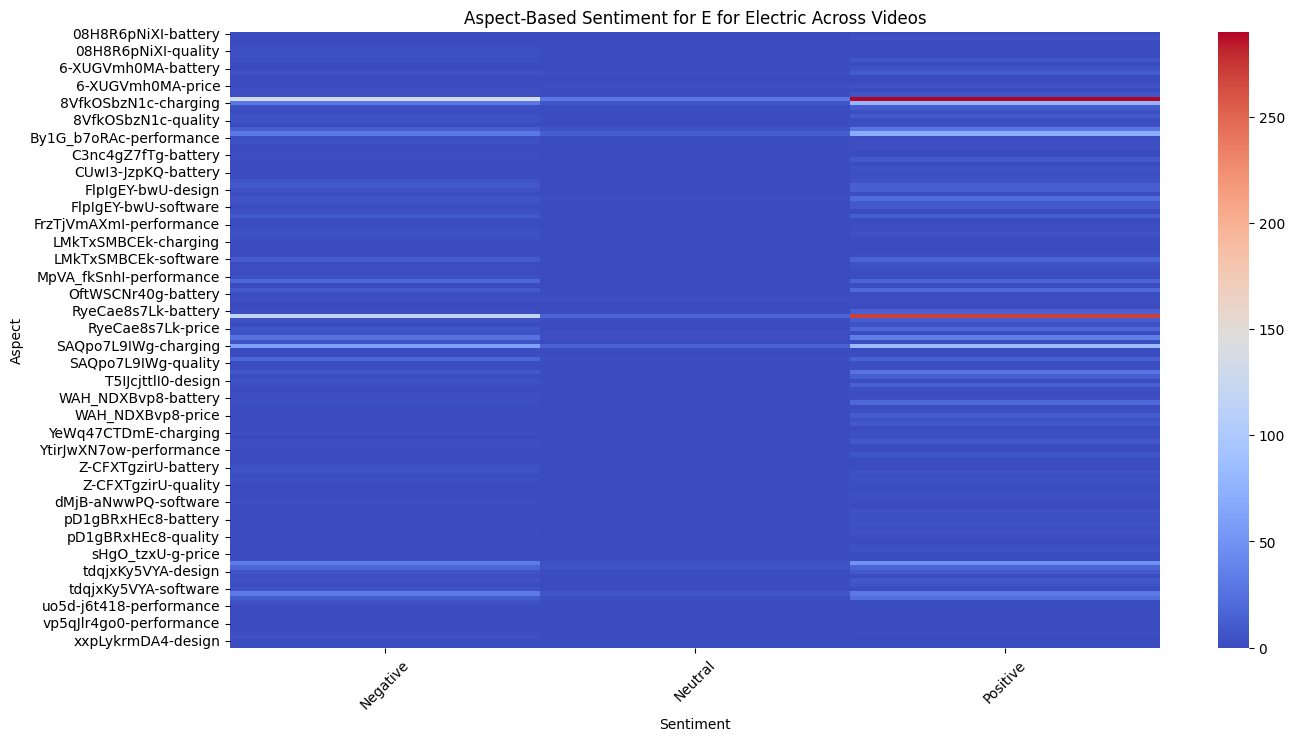

In [14]:
for creator in df["channel"].unique():
    creator_df = df[df["channel"] == creator].explode("aspects")
    aspect_video_sentiment = creator_df.groupby(["video_id", "aspects", "sentiment_roberta"]).size().unstack(fill_value=0)
    plt.figure(figsize=(15, 8))
    #sns.heatmap(aspect_video_sentiment, cmap="coolwarm", annot=True, fmt="d")
    sns.heatmap(aspect_video_sentiment, cmap="coolwarm", annot=False, fmt="d")
    plt.title(f"Aspect-Based Sentiment for {creator} Across Videos")
    plt.xlabel("Sentiment")
    plt.ylabel("Aspect")
    plt.xticks(rotation=45)
    plt.show()

**RoBERTa: Aspect-Based Sentiment Comparison per Creator (Each Row is an Aspect, Each Column is a Video)**

In [64]:
df.columns

Index(['channel', 'Negative', 'Neutral', 'Positive'], dtype='object')

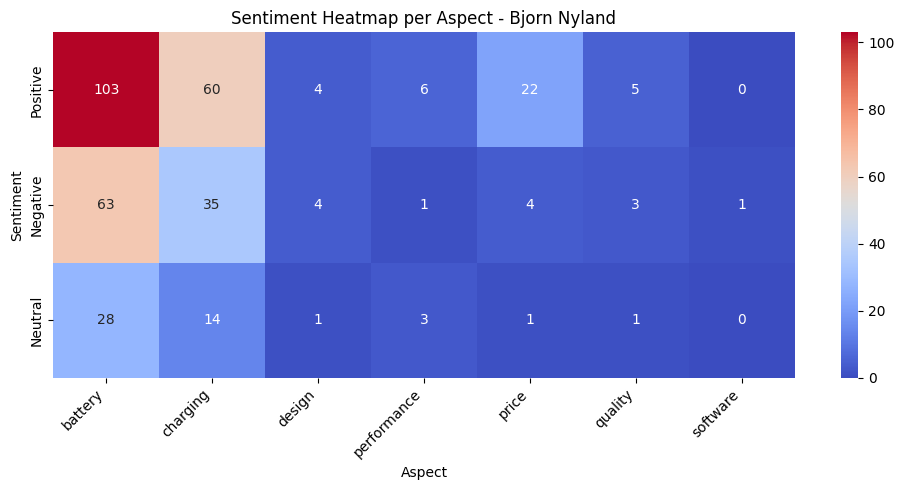

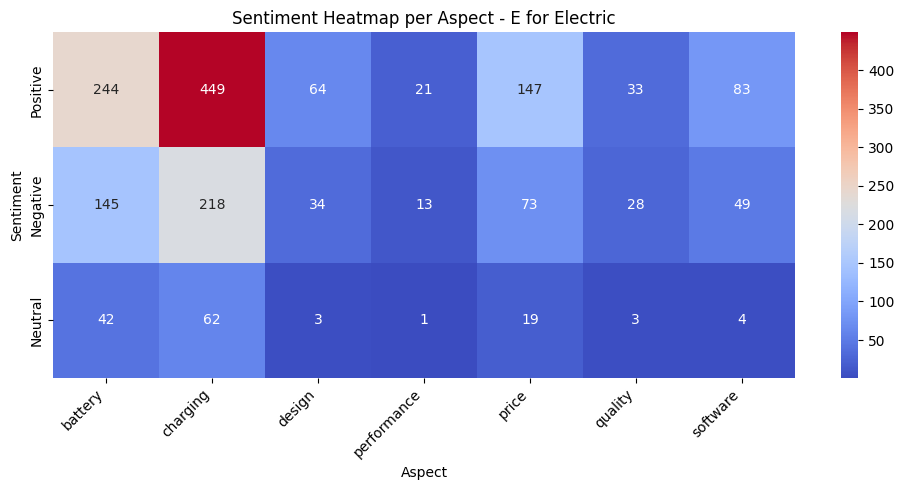

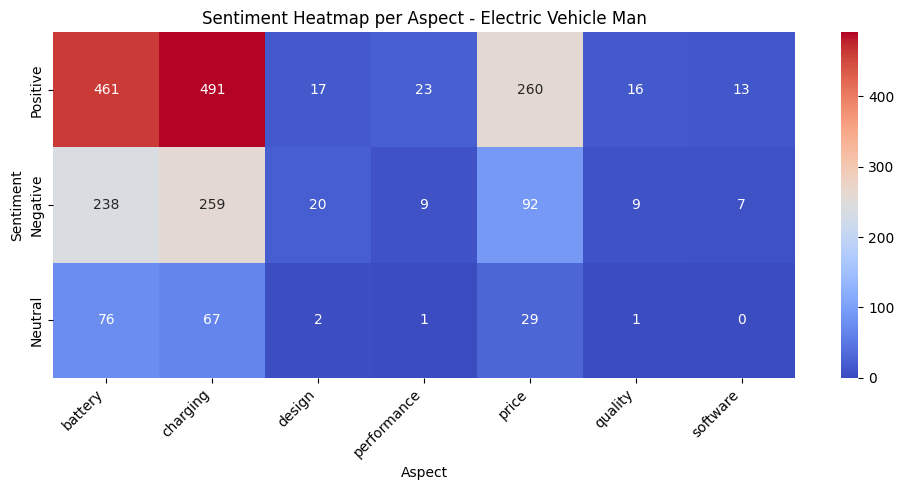

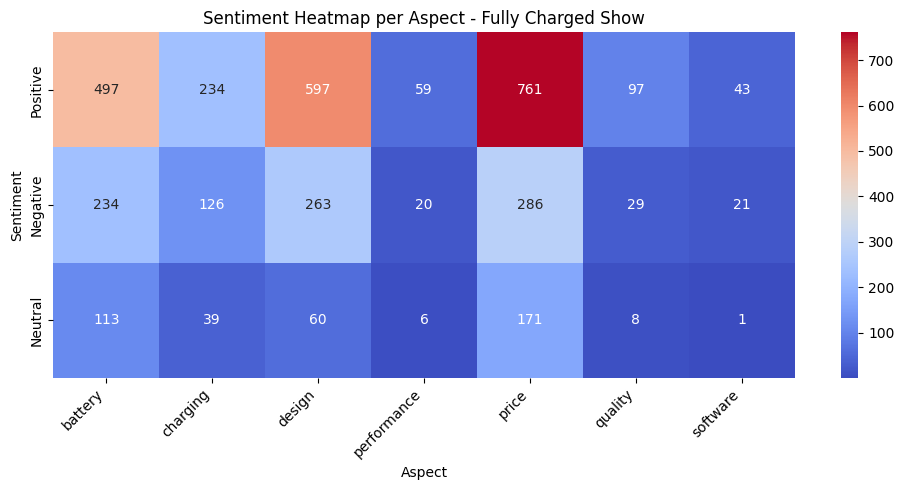

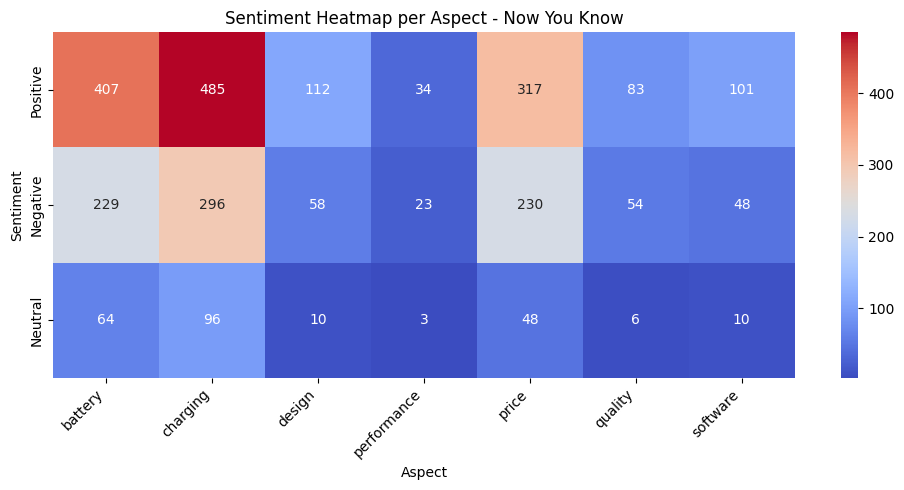

In [68]:
#ABSA heatmap per channel

df = pd.read_csv(r"C:\Users\koole\Documents\9) PLP Practice Module\Use Topics\For Chen Jia\LLM_Extracted Aspects_Roberta\comment_sentiment_roberta_PLP2.csv")

def find_matching_aspects(comment, top_aspects):
    if isinstance(comment, str):  # Ensure the comment is a string
        return [aspect for aspect in top_aspects if aspect in comment.lower()]
    else:
        return []  # Return an empty list if the comment is not a string

# Apply the function to the 'cleaned_text' column
df["matched_aspects"] = df["cleaned_text"].apply(lambda x: find_matching_aspects(x, top_aspects))

# Expand the dataframe and drop rows with no matched aspects
df_expanded = df.explode("matched_aspects")
df_expanded = df_expanded.dropna(subset=["matched_aspects"])

# Group by channel, matched aspects, and sentiment, then create a heatmap
grouped = df_expanded.groupby(["channel", "matched_aspects", "sentiment_roberta"]).size().unstack(fill_value=0).reset_index()

for channel in grouped["channel"].unique():
    subset = grouped[grouped["channel"] == channel].set_index("matched_aspects")[["Positive", "Negative", "Neutral"]]
    plt.figure(figsize=(10, 5))
    sns.heatmap(subset.T, annot=True, fmt="d", cmap="coolwarm")
    plt.title(f"Sentiment Heatmap per Aspect - {channel}")
    plt.ylabel("Sentiment")
    plt.xlabel("Aspect")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()



In [69]:
grouped.to_csv("LLM_topic_sentiment_per_creator_roberta.csv", index=True)

In [43]:
df.columns

Index(['channel', 'video_id', 'video_title', 'timestamp', 'comment',
       'cleaned_text', 'aspects', 'sentiment_roberta', 'date'],
      dtype='object')

C:\Users\koole\AppData\Local\Temp\ipykernel_16316\2870451935.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  video_comments['aspects'] = video_comments['aspects'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
C:\Users\koole\AppData\Local\Temp\ipykernel_16316\2870451935.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  video_comments['aspects'] = video_comments['aspects'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
C:\Users\koole\AppData\Local\Temp\ipykernel_

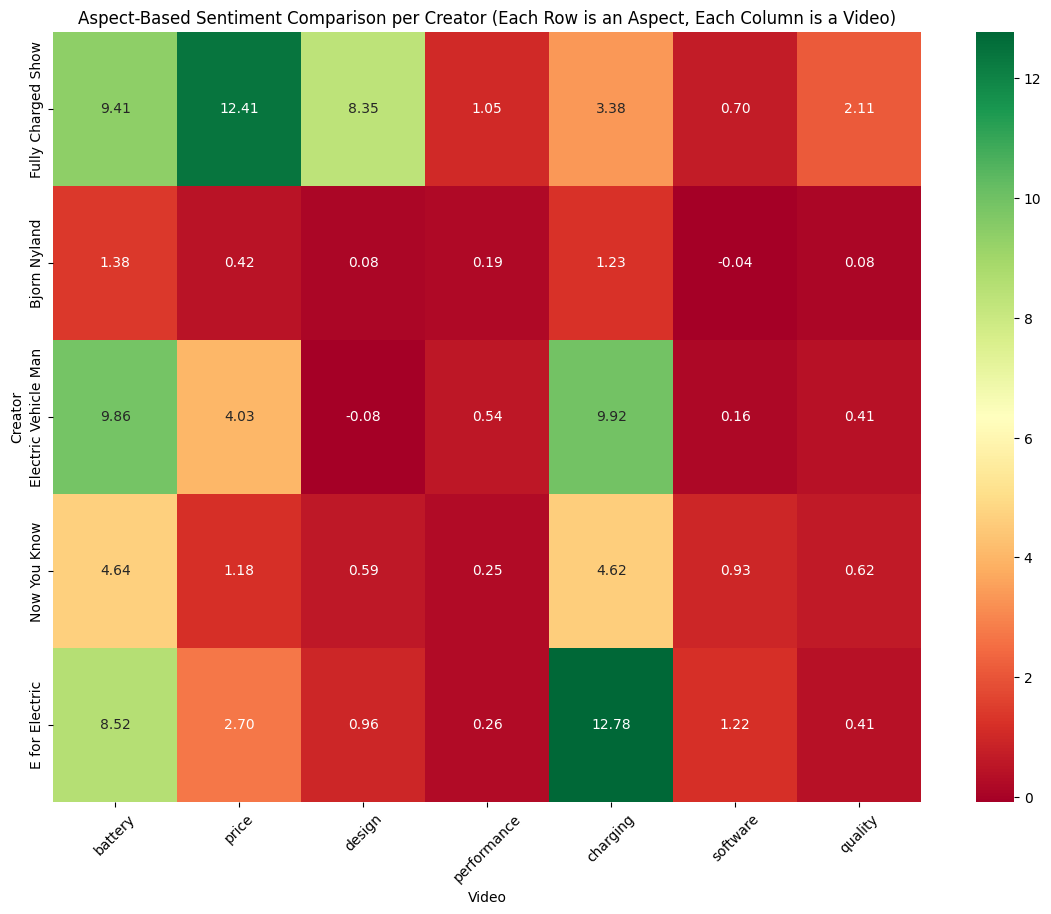

In [44]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Initialize an empty DataFrame to store the results
aspect_sentiment_matrix = pd.DataFrame()

# Iterate through each creator and calculate aspect sentiment for each video
for creator in df['channel'].unique():
    creator_df = df[df['channel'] == creator]
    creator_aspect_sentiment = []

    for video_id in creator_df['video_id'].unique():
        video_comments = creator_df[creator_df['video_id'] == video_id]
        aspect_sentiments = {aspect: 0 for aspect in common_aspects}

        import ast

        # Safely convert stringified lists into actual lists
        video_comments['aspects'] = video_comments['aspects'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

        # Update sentiment counts for each aspect in each comment
        for comment, sentiment in zip(video_comments['aspects'], video_comments['sentiment_roberta']):
            for aspect in comment:
                if aspect in aspect_sentiments:
                    aspect_sentiments[aspect] += 1 if sentiment == "Positive" else -1 if sentiment == "Negative" else 0

        creator_aspect_sentiment.append([aspect_sentiments[aspect] for aspect in common_aspects])

    # Convert the creator_aspect_sentiment list to a DataFrame
    creator_aspect_sentiment_df = pd.DataFrame(creator_aspect_sentiment, columns=common_aspects)

    # Add the DataFrame for this creator to the main aspect_sentiment_matrix
    aspect_sentiment_matrix[creator] = creator_aspect_sentiment_df.mean(axis=0)  # You can use mean or any other aggregation method


# Plot the heatmap with float formatting
plt.figure(figsize=(14, 10))
sns.heatmap(aspect_sentiment_matrix.T, annot=True, cmap="RdYlGn", fmt=".2f", cbar=True)
plt.title("Aspect-Based Sentiment Comparison per Creator (Each Row is an Aspect, Each Column is a Video)")
plt.xlabel('Video')
plt.ylabel('Creator')
plt.xticks(rotation=45)
plt.show()

In [45]:
creator_aspect_sentiment_df.to_csv("LLM_creator_aspect_sentiment_df_roberta.csv", index=True)

**RoBERTa: Heatmap per Creator Per Aspect Per Video (in one Heatmap)** 

Unique Aspects: ['[]' "['design', 'price']" "['quality']"
 "['battery', 'software', 'battery']" "['charging']"
 "['charging', 'price']" "['battery', 'price']" "['price']" "['battery']"
 "['design', 'design']" "['design']" "['quality', 'quality']"
 "['charging', 'charging']" "['price', 'battery']"
 "['battery', 'design', 'design']" "['performance']"
 "['battery', 'battery', 'battery']" "['battery', 'battery']"
 "['design', 'design', 'design', 'design', 'design']"
 "['battery', 'battery', 'battery', 'battery', 'price', 'battery', 'price', 'battery']"
 "['battery', 'charging', 'charging']" "['design', 'software']"
 "['performance', 'battery']" "['design', 'battery']"
 "['performance', 'price']" "['battery', 'design']"
 "['charging', 'battery']"
 "['charging', 'battery', 'charging', 'charging']" "['software']"
 "['battery', 'charging']" "['design', 'charging']"
 "['charging', 'battery', 'charging']"
 "['charging', 'battery', 'charging', 'charging', 'battery']"
 "['charging', 'charging', 'c

C:\Users\koole\AppData\Local\Temp\ipykernel_16316\108893060.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  video_comments['aspects'] = video_comments['aspects'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)


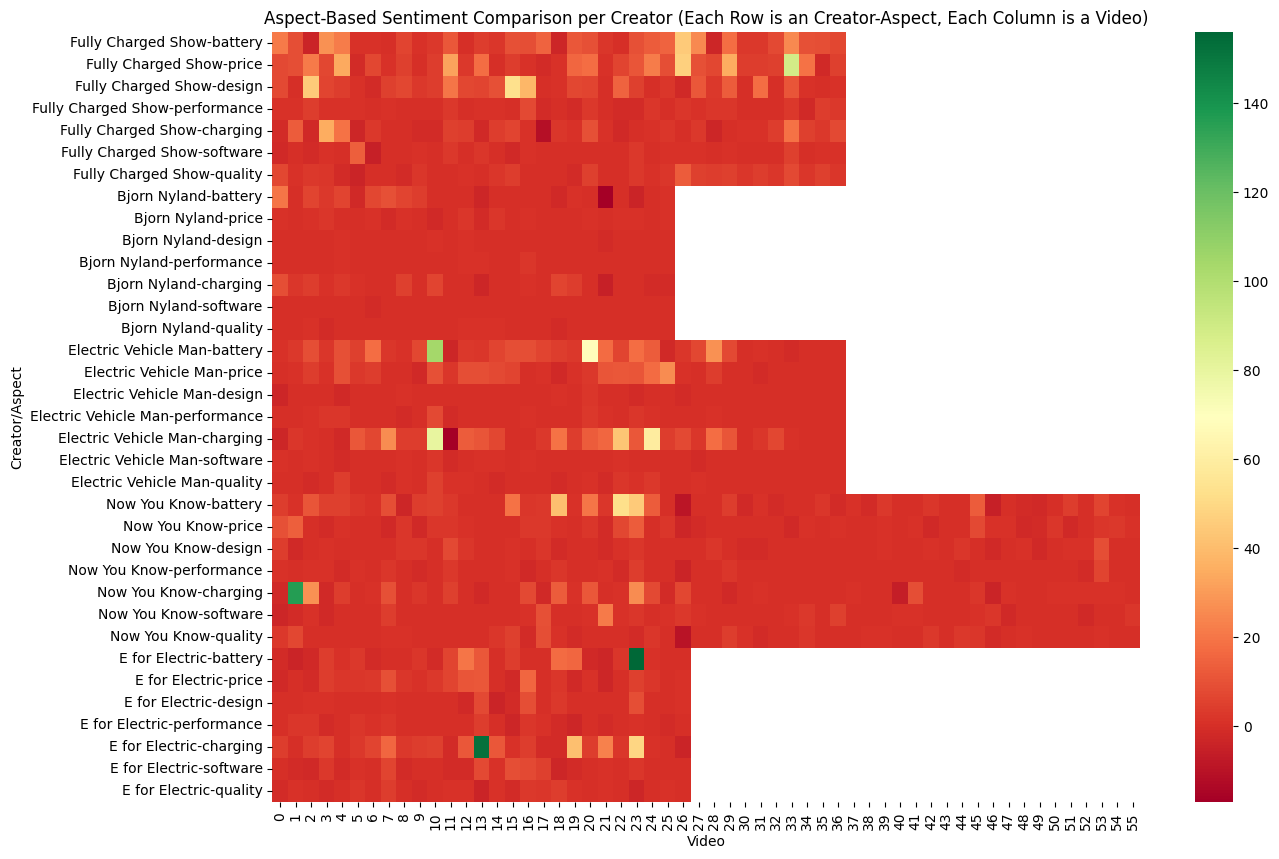

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Define top aspects (replace or modify these as needed)
top_aspects = ["battery", "price", "design", "performance", "charging", "software", "quality"]

# Extracted List of Unique Aspects (You should have this populated already)
aspects_list = df.explode("aspects")["aspects"].unique()
print("Unique Aspects:", aspects_list)

# Initialize a matrix for storing aspect sentiment data for each creator and video
aspect_sentiment_matrix = []

# Loop through each creator
for creator in df['channel'].unique():
    creator_df = df[df['channel'] == creator]
    creator_aspect_sentiment = []

    # Loop through each video
    for video_id in creator_df['video_id'].unique():
        video_comments = creator_df[creator_df['video_id'] == video_id]
        aspect_sentiments = {aspect: 0 for aspect in top_aspects}

        import ast

        # Safely convert stringified lists into actual lists
        video_comments['aspects'] = video_comments['aspects'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)


        # Loop through each comment and its sentiment
        for comment, sentiment in zip(video_comments['aspects'], video_comments['sentiment_roberta']):
            for aspect in comment:
                if aspect in aspect_sentiments:
                    # Increment/decrement based on sentiment
                    aspect_sentiments[aspect] += 1 if sentiment == "Positive" else -1 if sentiment == "Negative" else 0

        # Append the sentiment values for this video
        creator_aspect_sentiment.append([aspect_sentiments[aspect] for aspect in top_aspects])

    # Convert the list into a DataFrame for this creator and append it to the matrix
    creator_df_sentiment = pd.DataFrame(creator_aspect_sentiment, columns=top_aspects)
    aspect_sentiment_matrix.append(creator_df_sentiment)

# Concatenate all creator sentiment matrices horizontally (creating columns for each creator)
aspect_sentiment_matrix = pd.concat(aspect_sentiment_matrix, axis=1, keys=df['channel'].unique())

# Plot the overall aspect sentiment matrix
plt.figure(figsize=(14, 10))
#sns.heatmap(aspect_sentiment_matrix.T, annot=True, cmap="RdYlGn_r", fmt=".2f", cbar=True)  # Use ".2f" for floating point
sns.heatmap(aspect_sentiment_matrix.T, annot=False, cmap="RdYlGn", fmt=".2f", cbar=True)  # Use ".2f" for floating point
plt.title("Aspect-Based Sentiment Comparison per Creator (Each Row is an Creator-Aspect, Each Column is a Video)")
plt.xlabel('Video')
plt.ylabel('Creator/Aspect')
plt.show()



In [48]:
aspect_sentiment_matrix.to_csv("LLM_aspect_sentiment_matrix_roberta.csv", index=True)

**RoBERTa: Heatmap per Creator Per Aspect Per Video (One Heatmap Per Creator)** 

Unique Aspects: [nan 'design' 'price' 'quality' 'battery' 'software' 'charging'
 'performance']


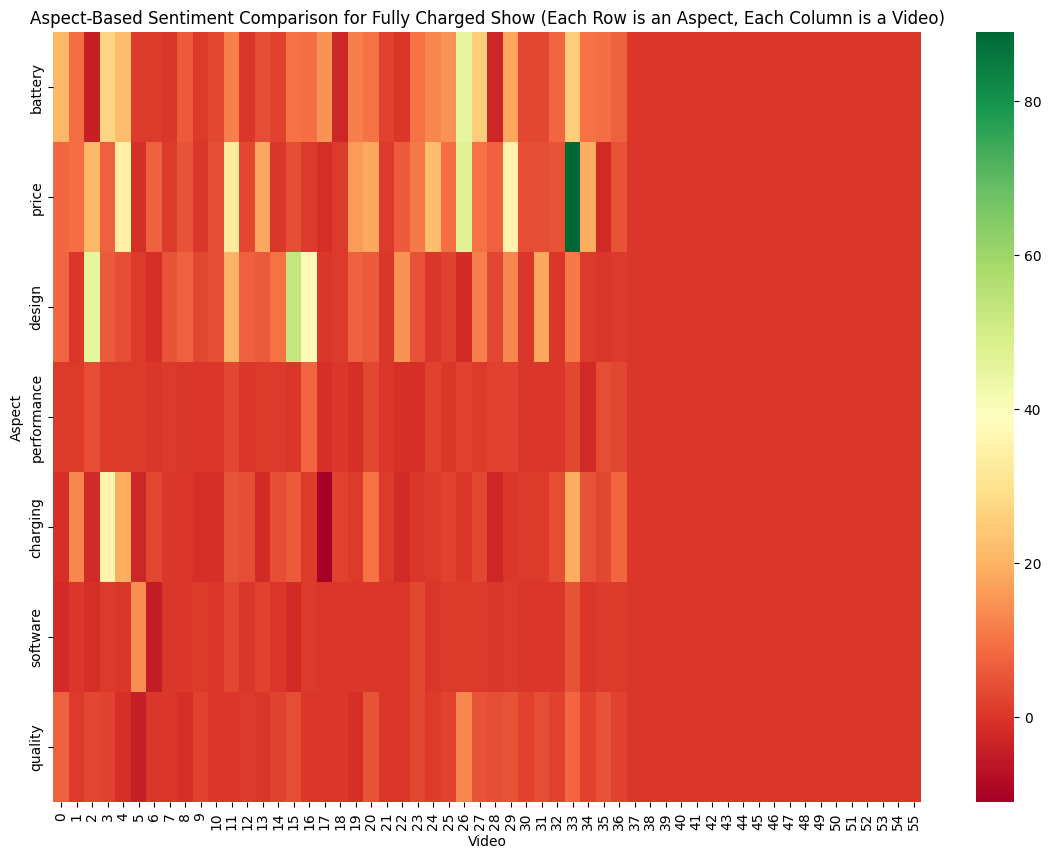

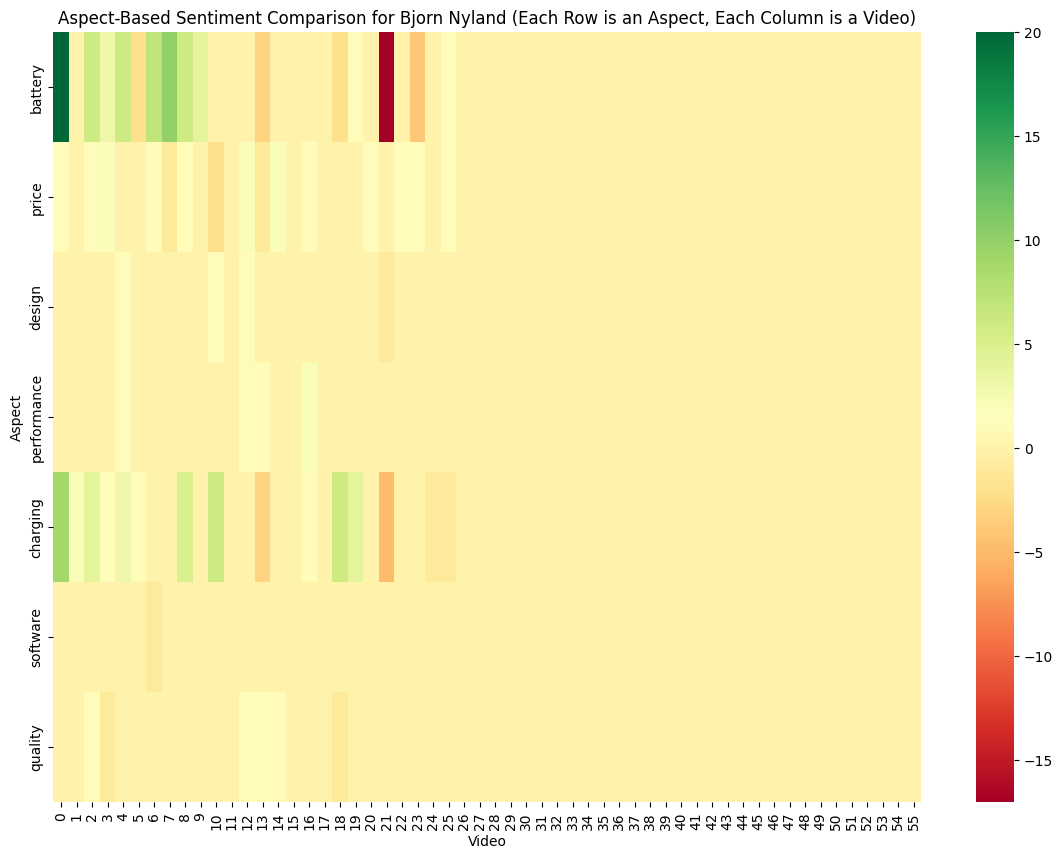

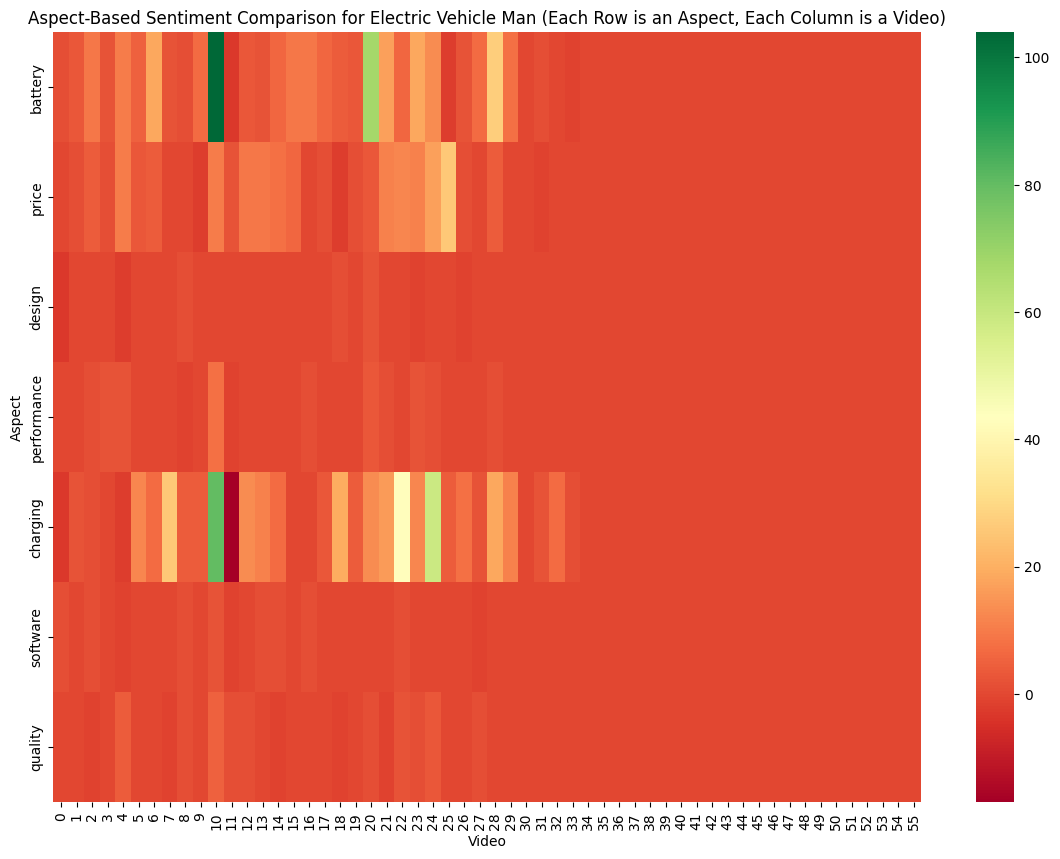

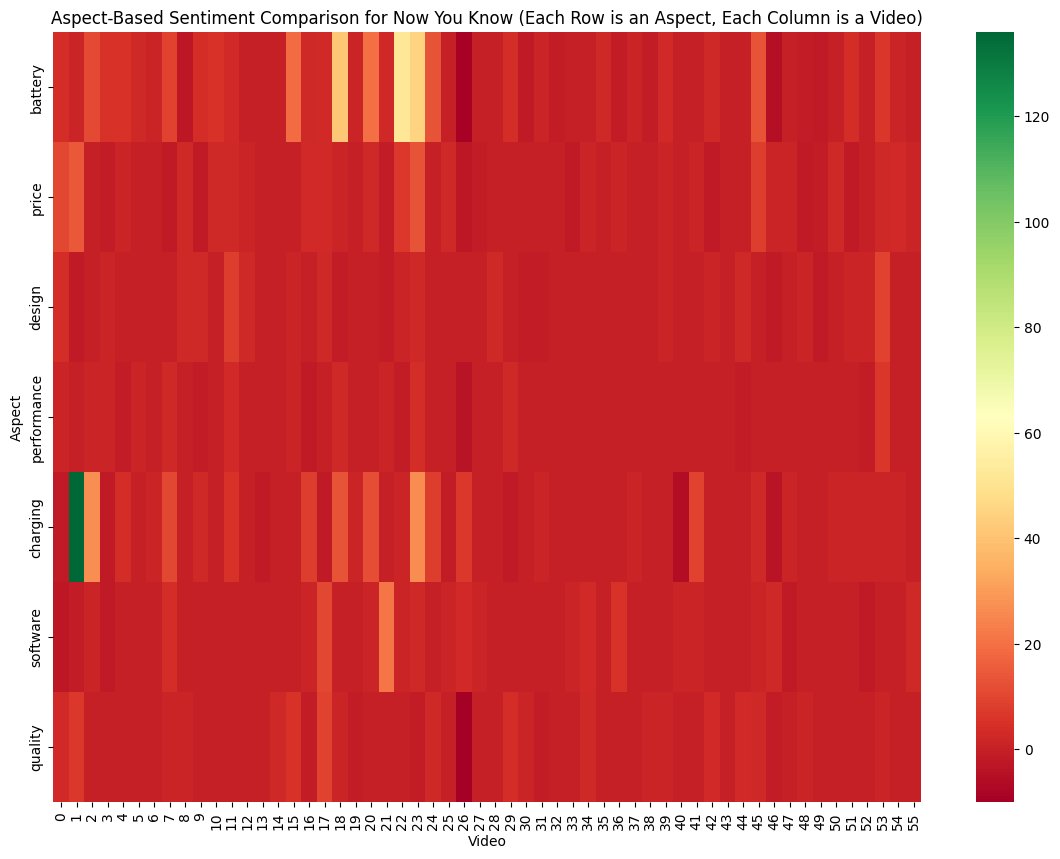

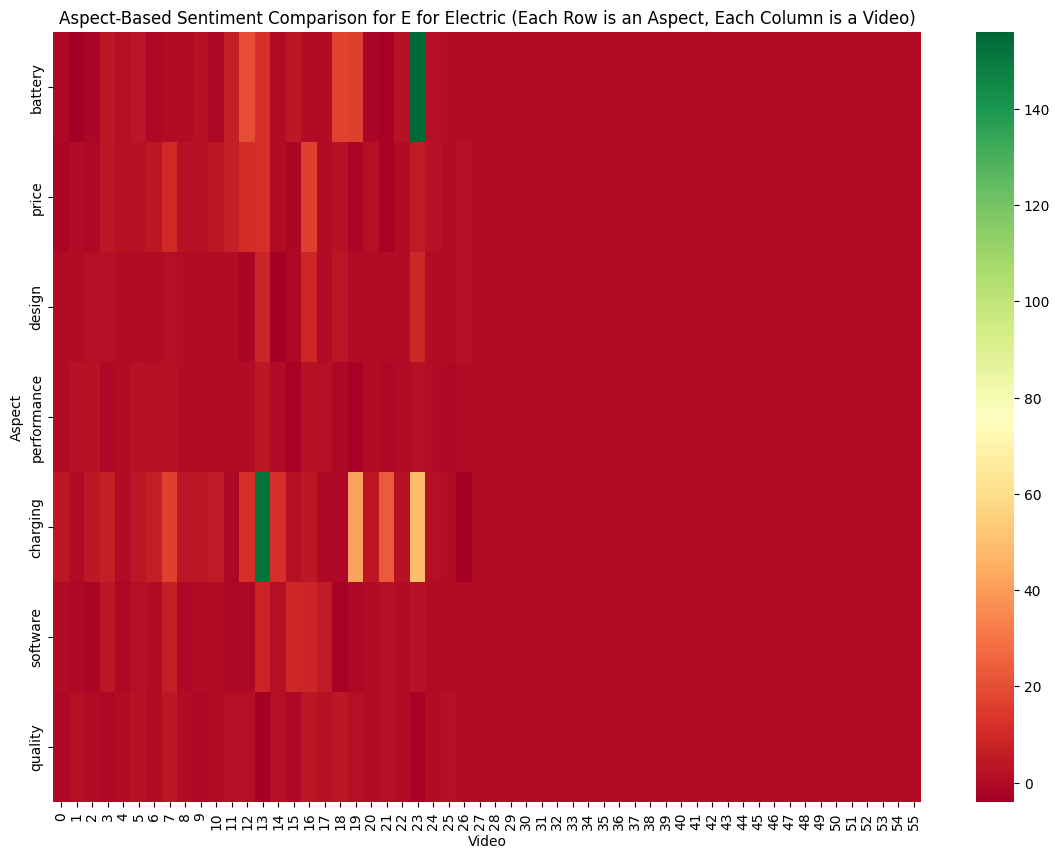

In [18]:
# Define top aspects (replace or modify these as needed)
top_aspects = ["battery", "price", "design", "performance", "charging", "software", "quality"]

# Extracted List of Unique Aspects (You should have this populated already)
aspects_list = df.explode("aspects")["aspects"].unique()
print("Unique Aspects:", aspects_list)

# Initialize a matrix for storing aspect sentiment data for each creator and video
aspect_sentiment_matrix = []

# Loop through each creator
for creator in df['channel'].unique():
    creator_df = df[df['channel'] == creator]
    creator_aspect_sentiment = []

    # Loop through each video
    for video_id in creator_df['video_id'].unique():
        video_comments = creator_df[creator_df['video_id'] == video_id]
        aspect_sentiments = {aspect: 0 for aspect in top_aspects}

        # Loop through each comment and its sentiment
        for comment, sentiment in zip(video_comments['aspects'], video_comments['sentiment_roberta']):
            for aspect in comment:
                if aspect in aspect_sentiments:
                    # Increment/decrement based on sentiment
                    aspect_sentiments[aspect] += 1 if sentiment == "Positive" else -1 if sentiment == "Negative" else 0

        # Append the sentiment values for this video
        creator_aspect_sentiment.append([aspect_sentiments[aspect] for aspect in top_aspects])

    # Add the creator's aspect sentiment data to the matrix
    aspect_sentiment_matrix.append(creator_aspect_sentiment)

# Convert the matrix into a DataFrame, ensuring each video has the same number of columns
max_videos = max(len(creator_aspect_sentiment) for creator_aspect_sentiment in aspect_sentiment_matrix)

# Fill with NaNs for creators with fewer videos
for idx, creator_sentiment in enumerate(aspect_sentiment_matrix):
    # If there are fewer videos for a creator, pad the list
    while len(creator_sentiment) < max_videos:
        creator_sentiment.append([0] * len(top_aspects))

# Convert into DataFrame, where each row corresponds to an aspect, and each column to a video
aspect_sentiment_matrix_df = pd.DataFrame(aspect_sentiment_matrix, 
                                          columns=[f"Video {i+1}" for i in range(max_videos)], 
                                          index=df['channel'].unique())

# Now plot for each creator's sentiment data
for creator, sentiment_data in zip(df['channel'].unique(), aspect_sentiment_matrix):
    creator_sentiment_df = pd.DataFrame(sentiment_data, columns=top_aspects)
    
    # Plot the aspect sentiment for this specific creator
    plt.figure(figsize=(14, 10))
    #sns.heatmap(creator_sentiment_df.T, annot=True, cmap="RdYlGn_r", fmt=".2f", cbar=True)
    sns.heatmap(creator_sentiment_df.T, annot=False, cmap="RdYlGn", fmt=".2f", cbar=True)
    plt.title(f"Aspect-Based Sentiment Comparison for {creator} (Each Row is an Aspect, Each Column is a Video)")
    plt.xlabel('Video')
    plt.ylabel('Aspect')
    plt.show()


In [49]:
aspect_sentiment_matrix_df.to_csv("LLM_aspect_sentiment_matrix_df_roberta.csv", index=True)

**Bar Plot: Total Number of Comments per Creator**

In [19]:
# total_comments = df["channel"].value_counts()
# plt.figure(figsize=(10, 5))
# sns.barplot(x=total_comments.index, y=total_comments.values, palette="viridis")
# plt.title("Total Number of Comments per Creator")
# plt.xlabel("Content Creator")
# plt.ylabel("Number of Comments")
# plt.xticks(rotation=45)
# plt.show()

**Time Series: Number of Comments Over Time per Creator**

In [20]:
# comment_time_series = df.groupby(["date", "channel"]).size().unstack(fill_value=0)
# plt.figure(figsize=(12, 6))
# sns.lineplot(data=comment_time_series)
# plt.title("Number of Comments Over Time by Content Creator")
# plt.xlabel("Date")
# plt.ylabel("Number of Comments")
# plt.xticks(rotation=45)
# plt.legend(title="Content Creator")
# plt.grid()
# plt.show()


**RoBERTa: Bar Plot: Total Number of Positive Comments per Creator**

C:\Users\koole\AppData\Local\Temp\ipykernel_16316\169250631.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=positive_comments_per_creator.index, y=positive_comments_per_creator.values, palette="viridis")


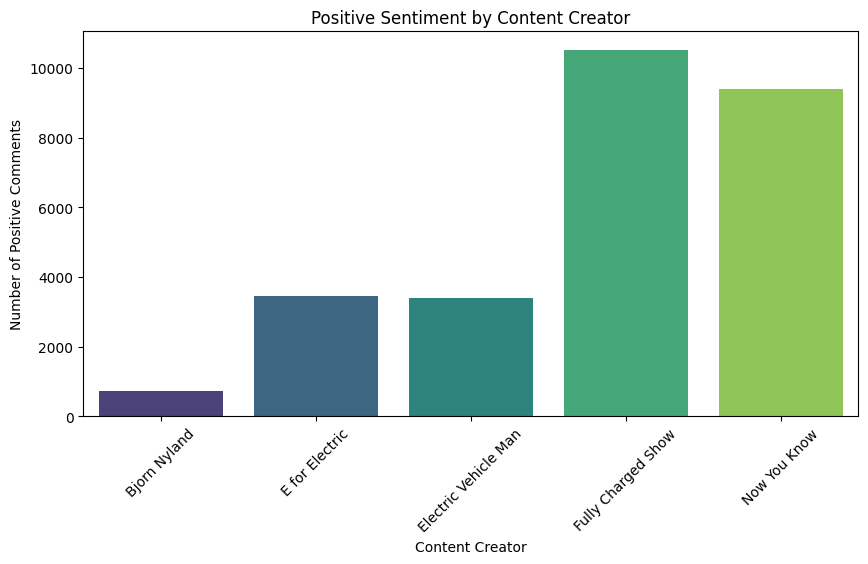

In [50]:
# Count the number of positive comments per creator
positive_comments_per_creator = df[df['sentiment_roberta'] == 'Positive'].groupby('channel').size()

# Plotting the number of positive comments per creator
plt.figure(figsize=(10, 5))
sns.barplot(x=positive_comments_per_creator.index, y=positive_comments_per_creator.values, palette="viridis")
plt.title("Positive Sentiment by Content Creator")
plt.xlabel("Content Creator")
plt.ylabel("Number of Positive Comments")
plt.xticks(rotation=45)
plt.show()

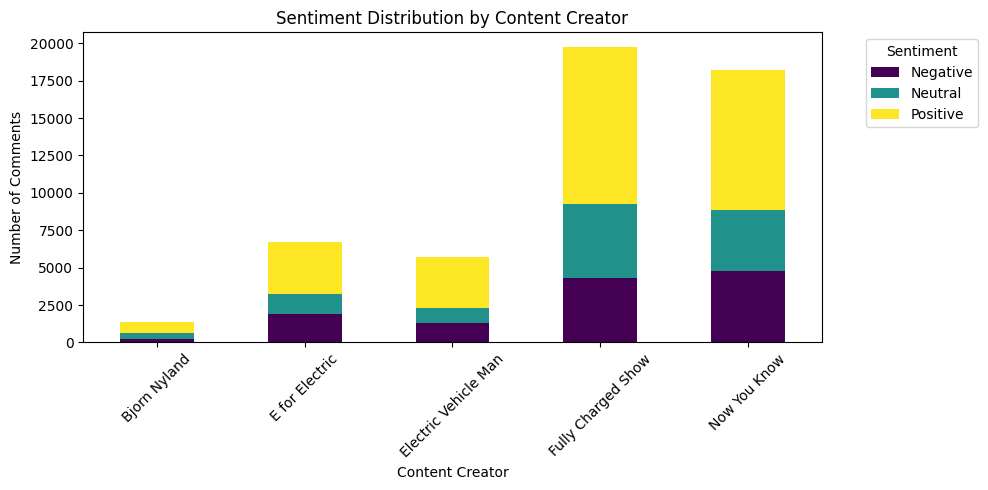

In [51]:
# Count the number of comments per sentiment per creator
comments_per_creator_sentiment = df.groupby(['channel', 'sentiment_roberta']).size().unstack(fill_value=0)

# Plotting the number of comments per sentiment (Positive, Negative, Neutral) per creator
comments_per_creator_sentiment.plot(kind='bar', stacked=True, figsize=(10, 5), colormap="viridis")

plt.title("Sentiment Distribution by Content Creator")
plt.xlabel("Content Creator")
plt.ylabel("Number of Comments")
plt.xticks(rotation=45)
plt.legend(title="Sentiment", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [52]:
comments_per_creator_sentiment.to_csv("LLM_comments_per_creator_sentiment_roberta.csv", index=True)

**RoBERTa: Time Series: Number of Positive Comments Over Time per Creator**

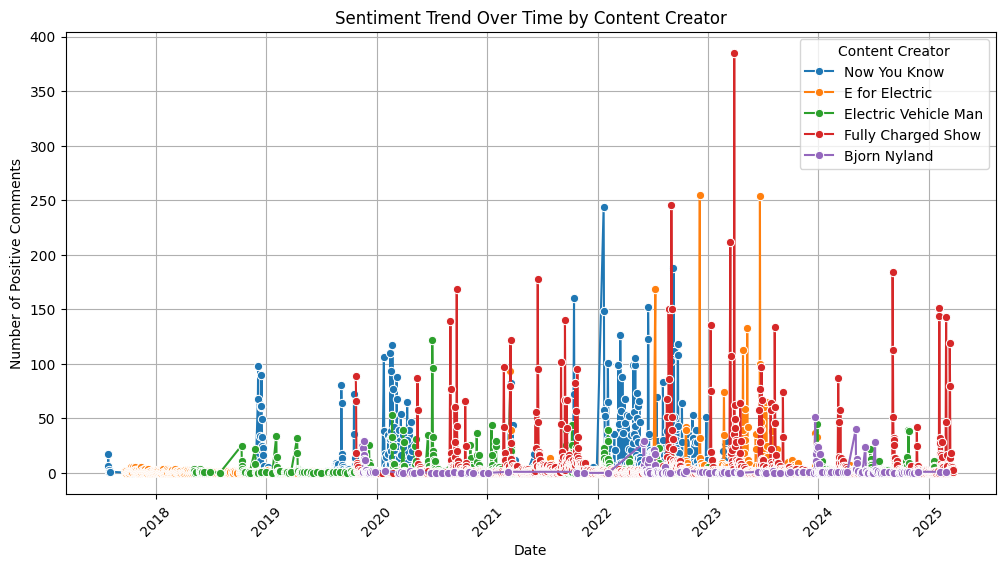

In [53]:
# Sentiment Distribution per Aspect
aspect_sentiment = df.explode("aspects").groupby(["aspects", "sentiment_roberta"]).size().unstack(fill_value=0)

# Compare Content Creators based on Sentiment
creator_sentiment = df.groupby(["channel", "sentiment_roberta"]).size().unstack(fill_value=0)

# Visualization: Sentiment Trends Over Time
df["timestamp"] = pd.to_datetime(df["timestamp"])
df["date"] = pd.to_datetime(df["timestamp"]).dt.date  # Ensure it's a proper date

# Aggregate sentiment counts per date and channel
sentiment_counts = df.groupby(["date", "channel"])["sentiment_roberta"].value_counts().unstack(fill_value=0).reset_index()

# Convert "date" back to datetime type
sentiment_counts["date"] = pd.to_datetime(sentiment_counts["date"])

# Plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=sentiment_counts, x="date", y="Positive", hue="channel", marker="o")

plt.title("Sentiment Trend Over Time by Content Creator")
plt.xlabel("Date")
plt.ylabel("Number of Positive Comments")
plt.xticks(rotation=45)
plt.legend(title="Content Creator")
plt.grid()
plt.show()


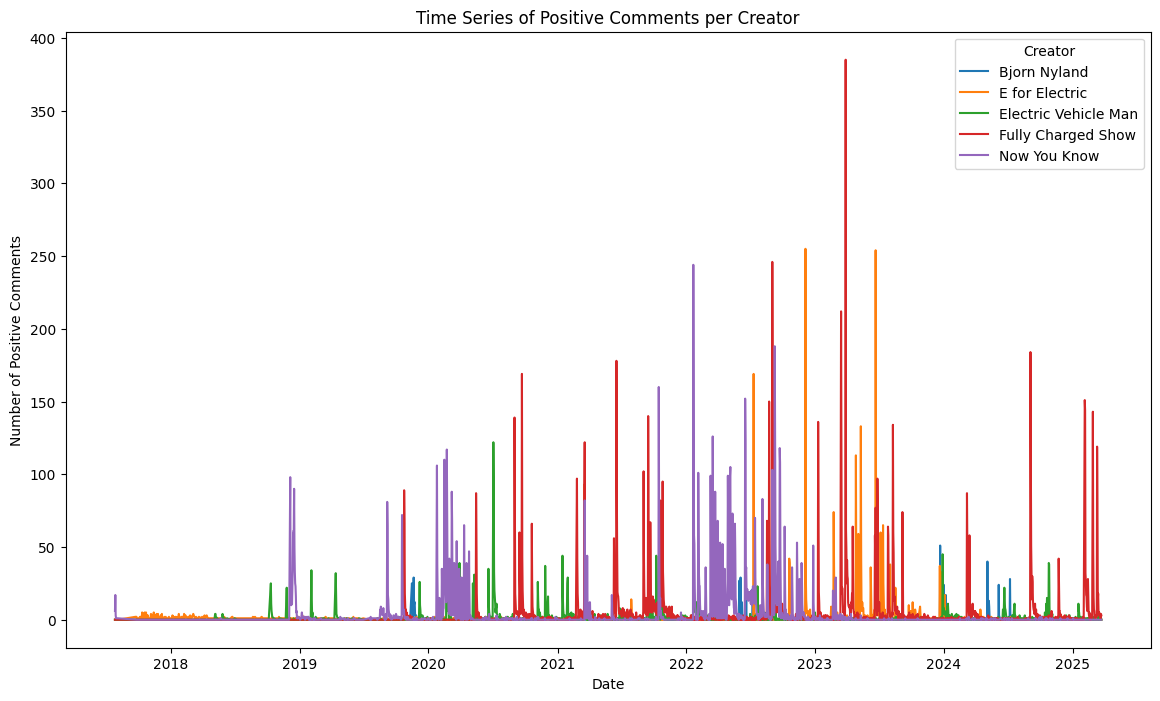

In [54]:
# Visualization: Sentiment Trends Over Time
df["timestamp"] = pd.to_datetime(df["timestamp"])
df["date"] = pd.to_datetime(df["timestamp"]).dt.date  # Ensure it's a proper date

# Time series of the number of positive comments received per creator
positive_comment_time_series = df[df['sentiment_roberta'] == 'Positive'].groupby(['date', 'channel']).size().unstack(fill_value=0)
positive_comment_time_series.plot(figsize=(14, 8), title="Time Series of Positive Comments per Creator")
plt.ylabel('Number of Positive Comments')
plt.xlabel('Date')
plt.legend(title="Creator")
plt.show()

In [56]:
positive_comment_time_series.to_csv("LLM_positive_comment_time_series_roberta.csv", index=True)

In [31]:
df.columns

Index(['channel', 'video_id', 'video_title', 'timestamp', 'comment',
       'cleaned_text', 'aspects', 'sentiment_roberta'],
      dtype='object')

In [72]:
df.columns

Index(['Unnamed: 0', 'channel', 'matched_aspects', 'Negative', 'Neutral',
       'Positive'],
      dtype='object')

C:\Users\koole\AppData\Local\Temp\ipykernel_16316\1044474265.py:22: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df_melted, x="matched_aspects", y="Count", hue="Sentiment", palette="Set2", ci=None)


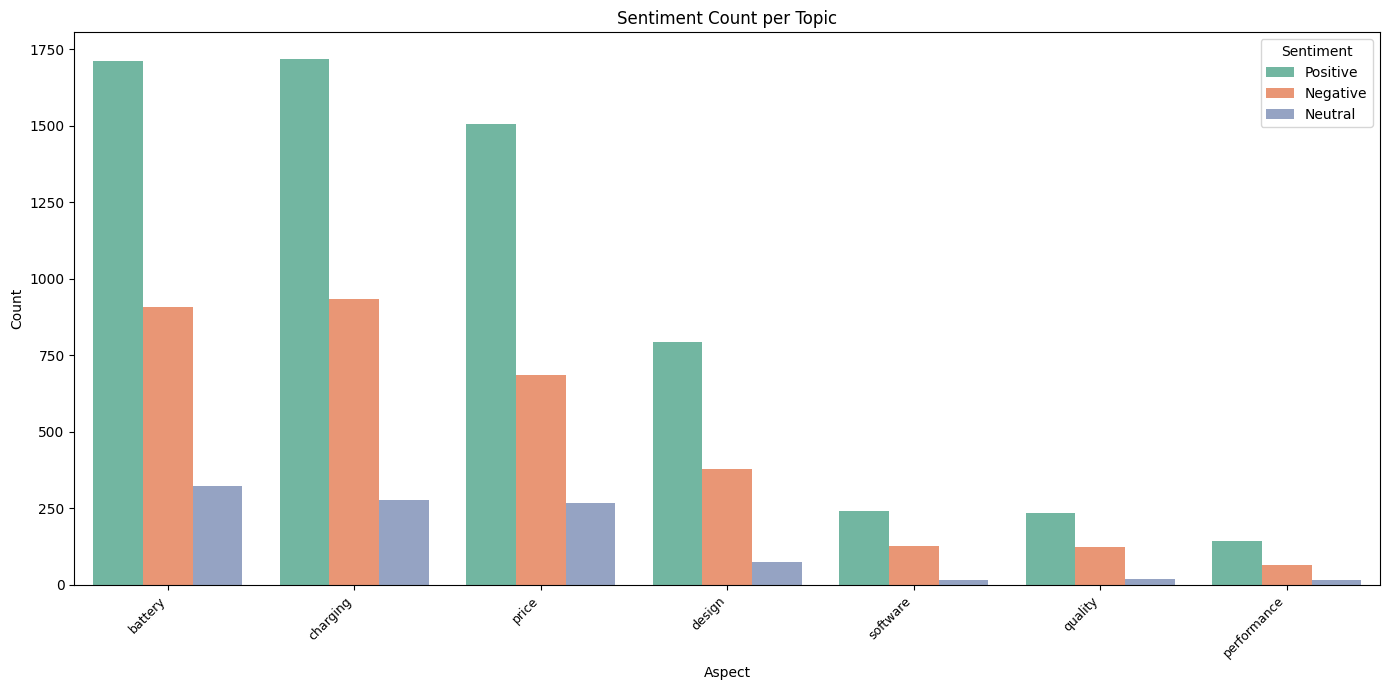

In [73]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the CSV
df = pd.read_csv(r"C:\Users\koole\Documents\9) PLP Practice Module\Use Topics\For Chen Jia\LLM_Extracted Aspects_Roberta\LLM_topic_sentiment_per_creator_roberta.csv") ##############

# Group by topic and aggregate sentiment counts
df_grouped = df.groupby("matched_aspects", as_index=False)[["Positive", "Negative", "Neutral"]].sum()

# Optional: Sort by total count
df_grouped["Total"] = df_grouped[["Positive", "Negative", "Neutral"]].sum(axis=1)
df_grouped = df_grouped.sort_values("Total", ascending=False)

# Melt for plotting
df_melted = df_grouped.melt(id_vars="matched_aspects", 
                            value_vars=["Positive", "Negative", "Neutral"],
                            var_name="Sentiment", value_name="Count")

# Plot grouped bar chart without error bars
plt.figure(figsize=(14, 7))
sns.barplot(data=df_melted, x="matched_aspects", y="Count", hue="Sentiment", palette="Set2", ci=None)

plt.title("Sentiment Count per Topic")
plt.xticks(rotation=45, ha='right', fontsize=9)
plt.xlabel("Aspect")
plt.ylabel("Count")
plt.legend(title="Sentiment")
plt.tight_layout()
plt.show()
